In [2]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# import importlib
# import utils
# importlib.reload(utils)

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import cv2
import scipy
from tqdm import tqdm

import skimage.io as io
import os

In [4]:
import pickle
import sys

In [5]:
sys.path.append('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/')

In [6]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py'>

# Read in data and trace particle positions

In [7]:
# read the image stack
foldername='/Volumes/maxone/20231012/0p5low_alg_12p5mM_2000ul_100um_20231012_095759_PM/'
imgname='0p5low_alg_12p5mM_2000ul_100um_20231012_94842_PM_20231012_095759_PM'
img_tif = io.imread(foldername+imgname+'.tif')

In [8]:
framerate=5647

In [9]:
scale_px=74/100 #px/um

In [10]:
ref=img_tif[3598]

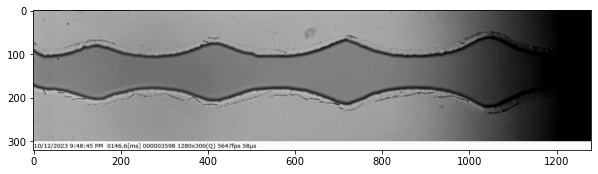

In [11]:
plt.imshow(ref)

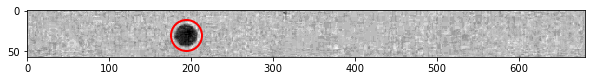

<AxesSubplot:>

In [12]:
crop_ys=113
crop_ye=170

crop_xs=229
crop_xe=910

frame=3261
size=31
target=img_tif[frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100
f_locate = tp.locate(target, size, minmass=1500, invert=True)
tp.annotate(f_locate, target, plot_style={'markersize': size})

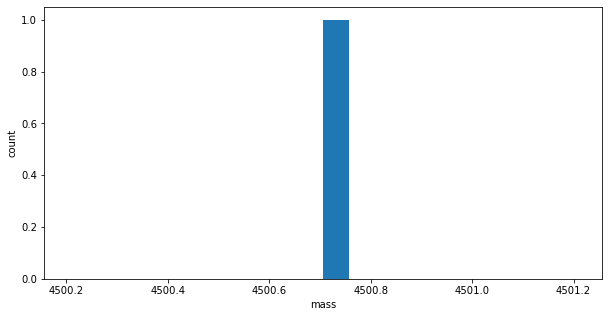

In [13]:
fig, ax = plt.subplots()
ax.hist(f_locate['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [14]:
start_frame=0
end_frame=7000


In [15]:
img_tif.shape

(7000, 320, 1280)

In [14]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    tp.batch(img_tif[start_frame:end_frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100,size, minmass=1500, invert=True, processes=1,output=s)

Frame 6999: 0 features


In [15]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 3 frames
    for linked in tp.link_df_iter(s, 100, memory=0,link_strategy='hybrid'):
        s.put(linked)

Frame 6871: 1 trajectories present.


In [16]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    t = pd.concat(iter(s))

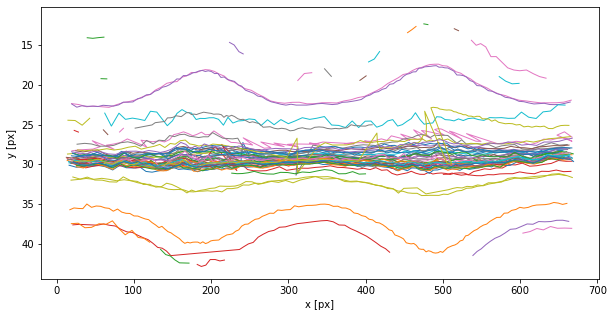

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [17]:
plt.figure()
tp.plot_traj(t)

In [18]:
t1 = tp.filter_stubs(t, 70)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 95
After: 42


In [19]:
t1_modified = t1.copy()
t1_modified['y'] = t1['y'] + crop_ys
t1_modified['x'] = t1['x'] + crop_xs
t1_modified['frame'] = t1['frame']+start_frame

In [20]:
t1_modified['particle'].unique()

array([ 0,  1, 17, 19, 21, 26, 28, 33, 35, 36, 37, 38, 39, 46, 50, 54, 55,
       57, 58, 60, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 88, 90, 94])

Text(0.5, 0, 's')

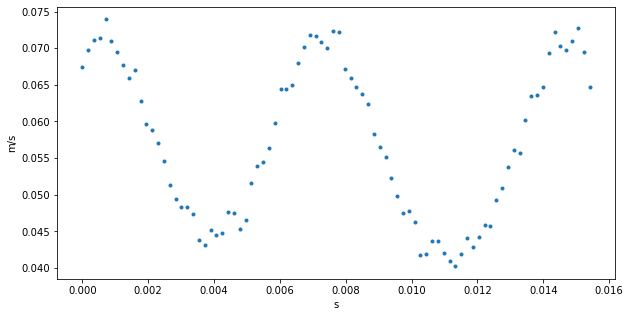

In [22]:
dt=1/framerate #s


x_pos=t1_modified[(t1_modified['particle'] == 1)]['x']
scale=10**(-6)/scale_px #um/px
v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

# Trace Particle Deformations

## some functions

## velocity and stress field
for one single beads
- sanity check for edge detection and fitting algorithm
- this beads gives the velocity and rescales for the stress field

In [23]:
t1_modified[t1_modified['particle']==1]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
253,142.536907,242.575785,3219.068380,8.724494,0.086523,10.539416,114998.0,NaN,253,1
254,142.284251,251.412242,3276.332880,8.935407,0.047907,10.605722,115447.0,NaN,254,1
255,142.495402,260.870880,3338.010202,8.593131,0.079333,12.172589,115263.0,NaN,255,1
256,142.444058,270.047074,3387.818289,8.854426,0.073758,10.920296,115493.0,NaN,256,1
257,142.673904,279.594451,3279.457205,9.050851,0.074627,11.469622,115363.0,NaN,257,1
...,...,...,...,...,...,...,...,...,...,...
336,142.171794,859.145196,3502.113105,9.153438,0.104243,9.680877,115543.0,NaN,336,1
337,141.951947,868.427281,3249.501632,8.866706,0.093452,10.263594,115440.0,NaN,337,1
338,141.334532,877.749014,3128.926033,8.977524,0.077355,9.550508,114847.0,NaN,338,1


In [24]:
yloc=142
xloc=242

roi=25
parts=img_tif[253][yloc-roi:yloc+roi,xloc-roi:xloc+roi]
blur_parts=cv2.GaussianBlur(parts,(7,7),3)

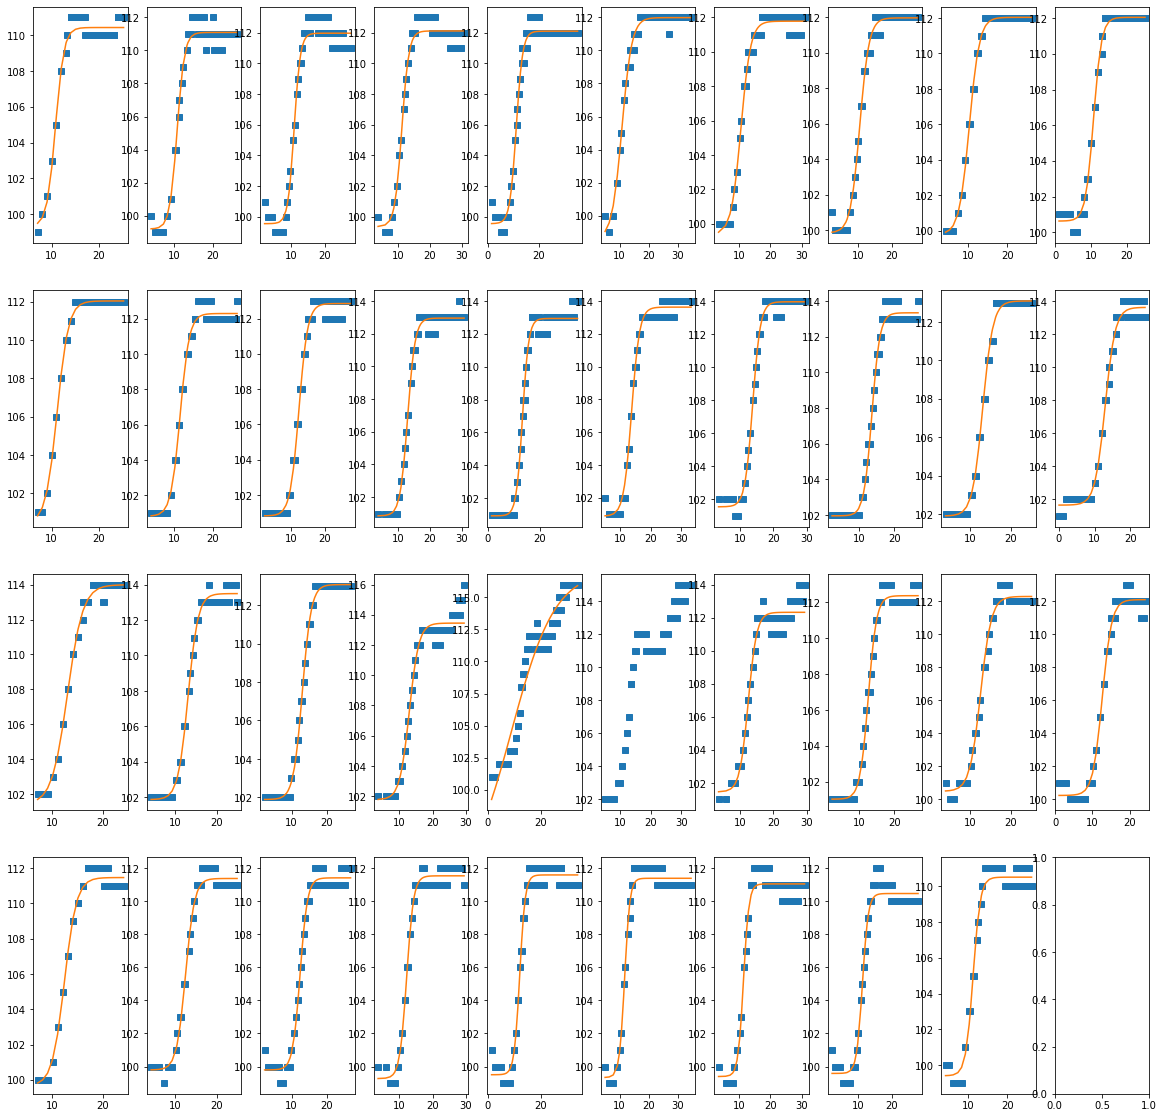

In [25]:
y_i, x_i=utils.detect_edge_sigmoid(blur_parts,roi,plot=True)

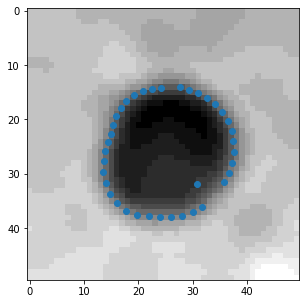

In [26]:
plt.imshow(blur_parts)
plt.plot(x_i,y_i,'o')

In [27]:
dire='/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/test/'
gamma_2 = utils.process_frames(img_tif,ref,t1_modified,1,dire)

frame number is253
frame number is254


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is255
frame number is256
frame number is257
frame number is258
frame number is259
frame number is260
frame number is261
frame number is262


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is263
frame number is264
frame number is265
frame number is266
frame number is267
frame number is268
frame number is269
frame number is270
frame number is271
frame number is272
frame number is273
frame number is274
frame number is275


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is276
frame number is277
frame number is278
frame number is279
frame number is280
frame number is281
frame number is282
frame number is283


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is284
frame number is285


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is286
frame number is287
frame number is288
frame number is289


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is290
frame number is291
frame number is292
frame number is293
frame number is294
frame number is295
frame number is296
frame number is297
frame number is298
frame number is299
frame number is300
frame number is301
frame number is302
frame number is303
frame number is304
frame number is305
frame number is306
frame number is307
frame number is308
frame number is309
frame number is310
frame number is311
frame number is312
frame number is313
frame number is314


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is315
frame number is316
frame number is317
frame number is318
frame number is319
frame number is320
frame number is321
frame number is322
frame number is323
frame number is324
frame number is325
frame number is326
frame number is327
frame number is328
frame number is329
frame number is330
frame number is331
frame number is332
frame number is333
frame number is334


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is335
frame number is336
frame number is337
frame number is338
frame number is339
frame number is340


### velocity

Text(0.5, 0, 's')

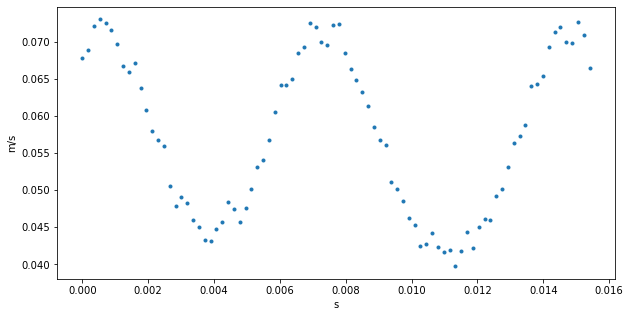

In [28]:
x_pos=t1_modified[(t1_modified['particle'] == 1)]['x']
v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

In [29]:
max_velocity=np.mean(sorted(v, reverse=True)[1:3])
print(max_velocity)

0.0725657128758579


### rescale for stress field

In [30]:
real_stress=utils.calculate_stress(max_velocity)
print('The real stess amplitude in this experiment is '+str(real_stress)+' Pa.')

Q is: 2542.7025791700603 ul/h
The real stess amplitude in this experiment is 8.837467175238407 Pa.


### fit for G' and G''

403.1948571550355
Storage modulus is:311.5617807300301
Loss modulus is:99.4019577002609
R^2: 0.18600302896852394
[ 0.02702305  2.83275703 -0.02444921]


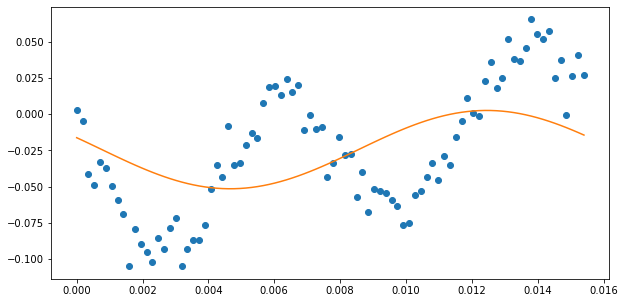

(311.5617807300301, 99.4019577002609, 403.1948571550355, 0.18600302896852394)

In [31]:
utils.calculate_modulus(framerate,gamma_2,real_stress)

# process all beads

## wavelength 1

In [32]:
wavelength1=t1_modified[(t1_modified['x'] >= 276) & (t1_modified['x'] <= 563)]

In [33]:
wavelength1['particle'].unique()

array([ 0,  1, 17, 19, 21, 26, 28, 33, 35, 36, 37, 38, 39, 46, 50, 54, 55,
       57, 58, 60, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 88, 90, 94])

In [34]:
# wavelength1 = wavelength1[wavelength1['particle'] != 5]
# wavelength1 = wavelength1[wavelength1['particle'] != 47]


In [34]:
gamma2list_w1=utils.analyze_wavelength_gamma2(wavelength1,1,imgname,img_tif,ref)

particle number: 0
frame number is2
frame number is3
frame number is4
frame number is5
frame number is6
frame number is7


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is8
frame number is9


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is10
frame number is11
frame number is12
frame number is13
frame number is14
frame number is15
frame number is16
frame number is17


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is18
frame number is19


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is20
frame number is21
frame number is22
frame number is23
frame number is24
frame number is25
frame number is26
frame number is27
frame number is28
frame number is29


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is30
frame number is31
frame number is32
frame number is33
frame number is34
frame number is35
frame number is36
frame number is37
frame number is38
particle number: 1
frame number is257
frame number is258
frame number is259
frame number is260
frame number is261
frame number is262
frame number is263
frame number is264
frame number is265
frame number is266
frame number is267
frame number is268
frame number is269
frame number is270
frame number is271
frame number is272
frame number is273
frame number is274


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is275
frame number is276
frame number is277
frame number is278
frame number is279
frame number is280
frame number is281
frame number is282


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is283
frame number is284
frame number is285
frame number is286
frame number is287
frame number is288
frame number is289
frame number is290


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is291
frame number is292
frame number is293
frame number is294
particle number: 17
frame number is371
frame number is372
frame number is373
frame number is374


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is375
frame number is376
frame number is377


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is378
frame number is379
frame number is380
frame number is381
frame number is382
frame number is383
frame number is384
frame number is385
frame number is386
frame number is387


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is388
frame number is389


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is390
frame number is391
frame number is392
frame number is393


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is394
frame number is395


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is396
frame number is397
frame number is398
frame number is399


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is400
frame number is401
frame number is402
frame number is403


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is404
frame number is405
frame number is406
frame number is407
frame number is408
particle number: 19
frame number is387


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is388
frame number is389
frame number is390
frame number is391
frame number is392
frame number is393
frame number is394
frame number is395


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is396
frame number is397


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is398
frame number is399
frame number is400
frame number is401
frame number is402
frame number is403
frame number is404
frame number is405
frame number is406
frame number is407
frame number is408
frame number is409
frame number is410
frame number is411


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is412
frame number is413
frame number is414
frame number is415
frame number is416
particle number: 21
frame number is668


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is669
frame number is670


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is671
frame number is672


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is673
frame number is674


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is675
frame number is676


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is677
frame number is678


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is679
frame number is680
frame number is681


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is682
frame number is683


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is684
frame number is685


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is686
frame number is687


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is688
frame number is689


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is690
frame number is691


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is692
frame number is693


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is694
frame number is695


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is696
frame number is697
frame number is698
frame number is699
frame number is700
frame number is701


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is702
frame number is703


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is704
frame number is705


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is706
frame number is707


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is708
frame number is709


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is710
frame number is711


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is712
frame number is713


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is714
frame number is715


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is716
frame number is717


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is718
frame number is719


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is720
frame number is721


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is722
frame number is723


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is724
frame number is725


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is726
frame number is727


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is728
frame number is729


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is730
frame number is731


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is732
particle number: 26
frame number is1026
frame number is1027
frame number is1028
frame number is1029
frame number is1030
frame number is1031
frame number is1032


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1033
frame number is1034
frame number is1035
frame number is1036


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1037
frame number is1038


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1039
frame number is1040
frame number is1041
frame number is1042


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1043
frame number is1044


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1045
frame number is1046
frame number is1047
frame number is1048
frame number is1049
frame number is1050
frame number is1051
frame number is1052
frame number is1053
frame number is1054
frame number is1055
frame number is1056


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1057
frame number is1058


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1059
frame number is1060
frame number is1061
frame number is1062
frame number is1063
particle number: 28
frame number is1072
frame number is1073
frame number is1074


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1075
frame number is1076


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1077
frame number is1078


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1079
frame number is1080


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1081
frame number is1082


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1083
frame number is1084


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1085
frame number is1086


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1087
frame number is1088


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1089
frame number is1090


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1091


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1092
frame number is1093


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1094
frame number is1095


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1096
frame number is1097


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1098
frame number is1099


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1100
frame number is1101


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1102
frame number is1103


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1104
frame number is1105


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1106
frame number is1107


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1108
particle number: 33
frame number is1462
frame number is1463
frame number is1464
frame number is1465
frame number is1466


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1467
frame number is1468
frame number is1469
frame number is1470
frame number is1471
frame number is1472
frame number is1473
frame number is1474
frame number is1475
frame number is1476
frame number is1477
frame number is1478


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1479
frame number is1480


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1481
frame number is1482


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1483
frame number is1484


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1485
frame number is1486


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1487
frame number is1488
frame number is1489
frame number is1490


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1491
frame number is1492
frame number is1493
frame number is1494
frame number is1495
frame number is1496
frame number is1497
frame number is1498
frame number is1499
particle number: 35
frame number is1504


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1505
frame number is1506
frame number is1507
frame number is1508


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1509
frame number is1510
frame number is1511
frame number is1512
frame number is1513
frame number is1514
frame number is1515
frame number is1516


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1517
frame number is1518
frame number is1519
frame number is1520


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1521
frame number is1522


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1523
frame number is1524


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1525
frame number is1526
frame number is1527
frame number is1528
frame number is1529
frame number is1530
frame number is1531
frame number is1532
frame number is1533
frame number is1534
frame number is1535
frame number is1536
frame number is1537
frame number is1538
frame number is1539
frame number is1540
frame number is1541
particle number: 36
frame number is1971
frame number is1973


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1974
frame number is1975


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1976
frame number is1977


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1978
frame number is1979
frame number is1980
frame number is1981


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1982
frame number is1983
frame number is1984
frame number is1985
frame number is1986
frame number is1987


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1988
frame number is1989


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1990
frame number is1991


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1992
frame number is1993


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1994
frame number is1995


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1996
frame number is1997


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1998
frame number is1999
frame number is2000
frame number is2001


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2002
frame number is2003


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2004
frame number is2005
frame number is2006
frame number is2007


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2008
frame number is2010


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


particle number: 37
frame number is2110
frame number is2111
frame number is2112
frame number is2113
frame number is2114
frame number is2115
frame number is2116
frame number is2117


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2118
frame number is2119


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2120
frame number is2121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2122
frame number is2123
frame number is2124
frame number is2125


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2126
frame number is2127
frame number is2128
frame number is2129
frame number is2130
frame number is2131
frame number is2132
frame number is2134


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2135
frame number is2136
frame number is2137
frame number is2138


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2139
frame number is2140


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2141
frame number is2142
frame number is2143
frame number is2144


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2145
frame number is2146


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


particle number: 38
frame number is2296
frame number is2297
frame number is2298
frame number is2299
frame number is2300
frame number is2301
frame number is2302
frame number is2303
frame number is2304
frame number is2305


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2306
frame number is2307
frame number is2308
frame number is2309
frame number is2310


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2311
frame number is2312
frame number is2313
frame number is2314
frame number is2315
frame number is2316
frame number is2317
frame number is2318


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2319
frame number is2320
frame number is2321
frame number is2322
frame number is2323
frame number is2324


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2325
frame number is2326


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2327
frame number is2328
frame number is2329
frame number is2330
frame number is2331
frame number is2332
frame number is2333
particle number: 39
frame number is2645
frame number is2646
frame number is2647
frame number is2648
frame number is2649
frame number is2650
frame number is2651
frame number is2652
frame number is2653
frame number is2654
frame number is2655


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2656
frame number is2657
frame number is2658
frame number is2659


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2660
frame number is2661
frame number is2662
frame number is2663
frame number is2664
frame number is2665
frame number is2666
frame number is2667
frame number is2668
frame number is2669


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2670
frame number is2671
frame number is2672
frame number is2673


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2674
frame number is2675
frame number is2676
frame number is2677


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2678
frame number is2679


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2680
frame number is2681
frame number is2682
particle number: 46
frame number is2693


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2694
frame number is2695


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2696
frame number is2697


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2698
frame number is2699


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2700
frame number is2701


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2702
frame number is2703


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2704
frame number is2705


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2706
frame number is2707


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2708
frame number is2709


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2710
frame number is2711


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2712
frame number is2713


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2714
frame number is2715
frame number is2716


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2717
frame number is2718


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2719
frame number is2720


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2721
frame number is2722


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2723
frame number is2724
frame number is2725
frame number is2726


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2727
frame number is2728


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2729
frame number is2730
particle number: 50
frame number is2758
frame number is2759
frame number is2760
frame number is2761
frame number is2762
frame number is2763
frame number is2764
frame number is2765


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2766
frame number is2767


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2768
frame number is2769
frame number is2770
frame number is2771
frame number is2772
frame number is2773
frame number is2774
frame number is2775
frame number is2776
frame number is2777
frame number is2778
frame number is2779
frame number is2780
frame number is2781
frame number is2782
frame number is2783
frame number is2784
frame number is2785
frame number is2786
frame number is2787
frame number is2788
frame number is2789
frame number is2790


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2791
frame number is2792
frame number is2793
frame number is2794
frame number is2795
particle number: 54
frame number is2825
frame number is2826
frame number is2827
frame number is2828
frame number is2829
frame number is2830
frame number is2831
frame number is2832
frame number is2833


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2834
frame number is2835
frame number is2836
frame number is2837
frame number is2838
frame number is2839
frame number is2840
frame number is2841
frame number is2842
frame number is2843
frame number is2844
frame number is2845


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2846
frame number is2847
frame number is2848
frame number is2849
frame number is2850
frame number is2851


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2852
frame number is2853
frame number is2854
frame number is2855


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2856
frame number is2857


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2858
frame number is2859


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2860
frame number is2861
frame number is2862
particle number: 55
frame number is2840
frame number is2841
frame number is2842
frame number is2843
frame number is2844
frame number is2845
frame number is2846


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2847
frame number is2848


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2849
frame number is2850
frame number is2851
frame number is2852
frame number is2853
frame number is2854
frame number is2855
frame number is2856
frame number is2857
frame number is2858
frame number is2859
frame number is2860
frame number is2861
frame number is2862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2863
frame number is2864
frame number is2865
frame number is2866
frame number is2867
frame number is2868


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2869
frame number is2870
frame number is2871
frame number is2872


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2873
frame number is2874
frame number is2875
frame number is2876
particle number: 57
frame number is2866
frame number is2867


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2868
frame number is2869
frame number is2870
frame number is2871
frame number is2872
frame number is2873


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2874
frame number is2875


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2876
frame number is2877


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2878
frame number is2879
frame number is2880
frame number is2881


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2882
frame number is2883
frame number is2884
frame number is2885


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2886
frame number is2887
frame number is2888
frame number is2889
frame number is2890
frame number is2891


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2892
frame number is2893
frame number is2894
frame number is2895


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2896
frame number is2897
frame number is2898
frame number is2899
frame number is2900
frame number is2901
frame number is2902
particle number: 58
frame number is2995


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2996
frame number is2997
frame number is2998
frame number is2999
frame number is3000
frame number is3001


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3002
frame number is3003
frame number is3004
frame number is3005
frame number is3006
frame number is3007
frame number is3008
frame number is3009


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3010
frame number is3011


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3012
frame number is3013
frame number is3014
frame number is3015
frame number is3016
frame number is3017
frame number is3018
frame number is3019
frame number is3020
frame number is3021
frame number is3022


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3023
frame number is3024


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3025
frame number is3026
frame number is3027
frame number is3028
frame number is3029
frame number is3030
frame number is3031
particle number: 60
frame number is3289
frame number is3290
frame number is3291


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3292
frame number is3293
frame number is3294
frame number is3295


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3296
frame number is3297
frame number is3298
frame number is3299


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3300
frame number is3301


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3302
frame number is3303


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3304
frame number is3305
frame number is3306
frame number is3307
frame number is3308
frame number is3309
frame number is3310
frame number is3311


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3312
frame number is3313
frame number is3314
frame number is3315
frame number is3316
frame number is3317


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3318
frame number is3319
frame number is3320
frame number is3321


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3322
frame number is3323


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3324
frame number is3325
particle number: 62
frame number is3676
frame number is3677
frame number is3678
frame number is3679
frame number is3680
frame number is3681
frame number is3682
frame number is3683


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3684
frame number is3685


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3686
frame number is3687
frame number is3688
frame number is3689


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3690
frame number is3691
frame number is3692
frame number is3693
frame number is3694
frame number is3695
frame number is3696
frame number is3697


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3698
frame number is3699
frame number is3700
frame number is3701
frame number is3702
frame number is3703


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3704
frame number is3705
frame number is3706
frame number is3707


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3708
frame number is3709


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3710
frame number is3711
frame number is3712
particle number: 63
frame number is4041
frame number is4042
frame number is4043


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4044
frame number is4045
frame number is4046
frame number is4047


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4048
frame number is4049
frame number is4050
frame number is4051


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4052
frame number is4053


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4054
frame number is4055
frame number is4056
frame number is4057
frame number is4058
frame number is4059


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4060
frame number is4061
frame number is4062
frame number is4063
frame number is4064
frame number is4065
frame number is4066
frame number is4067
frame number is4068
frame number is4069
frame number is4070
frame number is4071


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4072
frame number is4073
frame number is4074
frame number is4075


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4076
frame number is4077
frame number is4078
particle number: 64
frame number is4282


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4283
frame number is4284
frame number is4285
frame number is4286


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4287
frame number is4288


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4289
frame number is4290


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4291
frame number is4292


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4293
frame number is4294


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4295
frame number is4296
frame number is4297
frame number is4298


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4299
frame number is4300


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4301
frame number is4302


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4303
frame number is4304


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4305
frame number is4306
frame number is4307
frame number is4308


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4309
frame number is4310


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4311
frame number is4312
frame number is4313
frame number is4314


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4315
frame number is4316


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4317
frame number is4318
frame number is4319
frame number is4320


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4321
frame number is4322


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4323
frame number is4324


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4325
frame number is4326


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4327
frame number is4328


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4329
frame number is4330
frame number is4331
frame number is4332


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4333
frame number is4334


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4335
particle number: 65
frame number is4372


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4373
frame number is4374


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4375
frame number is4376


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4377
frame number is4378
frame number is4379
frame number is4380
frame number is4381
frame number is4382
frame number is4383
frame number is4384
frame number is4385
frame number is4386
frame number is4387
frame number is4388
frame number is4389
frame number is4390


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4391
frame number is4392
frame number is4393
frame number is4394


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4395
frame number is4396


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4397
frame number is4398


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4399
frame number is4400
frame number is4401
frame number is4402
frame number is4403
frame number is4404


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4405
frame number is4406
frame number is4407
frame number is4408
particle number: 67
frame number is4437
frame number is4438


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4439
frame number is4440
frame number is4441
frame number is4442
frame number is4443
frame number is4444


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4445
frame number is4446
frame number is4447
frame number is4448
frame number is4449
frame number is4450


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4451
frame number is4452
frame number is4453
frame number is4454
frame number is4455
frame number is4456
frame number is4457
frame number is4458
frame number is4459
frame number is4460


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4461
frame number is4462
frame number is4463
frame number is4464
frame number is4465
frame number is4466
frame number is4467
frame number is4468
frame number is4469
frame number is4470


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 69
frame number is4457
frame number is4458


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4459
frame number is4460


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4461
frame number is4462


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4463
frame number is4464


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4465
frame number is4466


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4467
frame number is4468
frame number is4469
frame number is4470


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4471
frame number is4472


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4473
frame number is4474


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4475
frame number is4476


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4477
frame number is4478


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4479
frame number is4480
frame number is4481
frame number is4482


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4483
frame number is4484


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4485
frame number is4486


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4487
frame number is4488


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4489
frame number is4490
frame number is4491
frame number is4492


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4493
particle number: 70
frame number is4832


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4833
frame number is4834


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4835
frame number is4836


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4837
frame number is4838


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4839
frame number is4840
frame number is4841
frame number is4842


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4843
frame number is4844


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4845
frame number is4846


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4847
frame number is4848


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4849
frame number is4850


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4851
frame number is4852


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4853
frame number is4854


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4855
frame number is4856


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4857
frame number is4858


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4859
frame number is4860


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4861
frame number is4862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4863
frame number is4864
frame number is4865
frame number is4866


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4867
frame number is4868


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4869
frame number is4870


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 71
frame number is4972
frame number is4973


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4974
frame number is4975
frame number is4976
frame number is4977


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4978
frame number is4979
frame number is4980
frame number is4981


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4982
frame number is4983


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4984
frame number is4985
frame number is4986
frame number is4987


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4988
frame number is4989
frame number is4990
frame number is4991
frame number is4992
frame number is4993
frame number is4994
frame number is4995
frame number is4996
frame number is4997


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4998
frame number is4999


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5000
frame number is5001
frame number is5002
frame number is5003
frame number is5004
frame number is5005
frame number is5006
frame number is5007
frame number is5008
particle number: 72
frame number is5030
frame number is5031
frame number is5032
frame number is5033
frame number is5034
frame number is5035
frame number is5036


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5037
frame number is5038
frame number is5039
frame number is5040
frame number is5041
frame number is5042
frame number is5043
frame number is5044
frame number is5045
frame number is5046
frame number is5047
frame number is5048
frame number is5049
frame number is5050
frame number is5051
frame number is5052
frame number is5053
frame number is5054


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5055
frame number is5056
frame number is5057
frame number is5058
frame number is5059
frame number is5060


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5061
frame number is5062
frame number is5063
frame number is5064


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5065
frame number is5066


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 73
frame number is5070
frame number is5071
frame number is5072
frame number is5073
frame number is5074
frame number is5075
frame number is5076
frame number is5077


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5078
frame number is5079
frame number is5080
frame number is5081


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5082
frame number is5083
frame number is5084
frame number is5085
frame number is5086
frame number is5087
frame number is5088
frame number is5089
frame number is5090
frame number is5091
frame number is5092
frame number is5093


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5094
frame number is5095
frame number is5096
frame number is5097
frame number is5098
frame number is5099


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5100
frame number is5101
frame number is5102
frame number is5103


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5104
frame number is5105
frame number is5106
frame number is5107


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 74
frame number is5087
frame number is5088
frame number is5089
frame number is5090
frame number is5091
frame number is5092


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5093
frame number is5094
frame number is5095
frame number is5096


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5097
frame number is5098


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5099
frame number is5100
frame number is5101
frame number is5102
frame number is5103
frame number is5104


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5105
frame number is5106
frame number is5107
frame number is5108
frame number is5109
frame number is5110


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5111
frame number is5112
frame number is5113
frame number is5114
frame number is5115
frame number is5116
frame number is5117
frame number is5118
frame number is5119
frame number is5120
frame number is5121
frame number is5122
frame number is5123
particle number: 75
frame number is5110
frame number is5111
frame number is5112


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5113
frame number is5114
frame number is5115
frame number is5116
frame number is5117
frame number is5118


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5119
frame number is5120
frame number is5121
frame number is5122


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5123
frame number is5124


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5125
frame number is5126


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5127
frame number is5128
frame number is5129
frame number is5130


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5131
frame number is5132


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5133
frame number is5134
frame number is5135
frame number is5136


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5137
frame number is5138


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5139
frame number is5140
frame number is5141
frame number is5142


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5143
frame number is5144
frame number is5145
frame number is5146
particle number: 76
frame number is5188
frame number is5189
frame number is5190
frame number is5191
frame number is5192
frame number is5193


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5194
frame number is5195
frame number is5196
frame number is5197


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5198
frame number is5199
frame number is5200
frame number is5201
frame number is5202
frame number is5203
frame number is5204
frame number is5205


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5206
frame number is5207
frame number is5208
frame number is5209
frame number is5210
frame number is5211


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5212
frame number is5213
frame number is5214
frame number is5215
frame number is5216
frame number is5217
frame number is5218
frame number is5219
frame number is5220
frame number is5221
frame number is5222
frame number is5223
frame number is5224
frame number is5225
particle number: 77
frame number is5276
frame number is5277
frame number is5278
frame number is5279
frame number is5280
frame number is5281
frame number is5282
frame number is5283


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5284
frame number is5285
frame number is5286
frame number is5287
frame number is5288
frame number is5289
frame number is5290
frame number is5291
frame number is5292
frame number is5293
frame number is5294
frame number is5295
frame number is5296
frame number is5297
frame number is5298
frame number is5299
frame number is5300
frame number is5301
frame number is5302
frame number is5303
frame number is5304
frame number is5305
frame number is5306
frame number is5307
frame number is5308
frame number is5309
frame number is5310
frame number is5311
frame number is5312
frame number is5313
particle number: 78
frame number is5597
frame number is5598


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5599
frame number is5600
frame number is5601
frame number is5602


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5603
frame number is5604


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5605
frame number is5606
frame number is5607
frame number is5608
frame number is5609
frame number is5610
frame number is5611
frame number is5612
frame number is5613
frame number is5614


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5615
frame number is5616


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5617
frame number is5618
frame number is5619
frame number is5630
frame number is5631
frame number is5632


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 79
frame number is5692
frame number is5693


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5694
frame number is5695
frame number is5696
frame number is5697
frame number is5698
frame number is5699
frame number is5700
frame number is5701
frame number is5702
frame number is5703
frame number is5704
frame number is5705
frame number is5706
frame number is5707
frame number is5708
frame number is5709
frame number is5710
frame number is5711
frame number is5712
frame number is5713
frame number is5714
frame number is5715


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5716
frame number is5717
frame number is5718
frame number is5719
frame number is5720
frame number is5721


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5722
frame number is5723
frame number is5724
frame number is5725
frame number is5726
frame number is5727
frame number is5728
particle number: 80
frame number is5889
frame number is5890
frame number is5891


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5892
frame number is5893
frame number is5894
frame number is5895


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5896
frame number is5897
frame number is5898
frame number is5899


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5900
frame number is5901


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5902
frame number is5903


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5904
frame number is5905
frame number is5906
frame number is5907
frame number is5908
frame number is5909
frame number is5910
frame number is5911


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5912
frame number is5913


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5914
frame number is5915
frame number is5916
frame number is5917


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5918
frame number is5919
frame number is5920
frame number is5921
frame number is5922
frame number is5923
frame number is5924
frame number is5925
frame number is5926
particle number: 81
frame number is5921
frame number is5922
frame number is5923
frame number is5924
frame number is5925
frame number is5926
frame number is5927


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5928
frame number is5929


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5930
frame number is5931


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5932
frame number is5933


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5934
frame number is5935
frame number is5936
frame number is5937


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5938
frame number is5939


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5940
frame number is5941
frame number is5942
frame number is5943
frame number is5944
frame number is5945


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5946
frame number is5947
frame number is5948
frame number is5949
frame number is5950
frame number is5951


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5952
frame number is5953
frame number is5954
frame number is5955
frame number is5956
frame number is5957
particle number: 82
frame number is6075
frame number is6076
frame number is6077
frame number is6078


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6079
frame number is6080
frame number is6081
frame number is6082
frame number is6083
frame number is6084
frame number is6085
frame number is6086
frame number is6087
frame number is6088
frame number is6089
frame number is6090


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6091
frame number is6092
frame number is6093
frame number is6094
frame number is6095
frame number is6096


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6097
frame number is6098
frame number is6099
frame number is6100
frame number is6101
frame number is6102
frame number is6103
frame number is6104


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6105
frame number is6106
frame number is6107
frame number is6108


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6109
frame number is6110
frame number is6111
particle number: 88
frame number is6187
frame number is6188
frame number is6189


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6190
frame number is6191
frame number is6192
frame number is6193
frame number is6194
frame number is6195


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6196
frame number is6197
frame number is6198
frame number is6199
frame number is6200
frame number is6201


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6202
frame number is6203


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6204
frame number is6205
frame number is6206
frame number is6207
frame number is6208
frame number is6209
frame number is6210
frame number is6211
frame number is6212
frame number is6213
frame number is6214
frame number is6215
frame number is6216
frame number is6217
frame number is6218
frame number is6219
frame number is6220
frame number is6221
frame number is6222
frame number is6223
particle number: 90
frame number is6475
frame number is6476
frame number is6477
frame number is6478
frame number is6479
frame number is6480
frame number is6481
frame number is6482


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6483
frame number is6484
frame number is6485
frame number is6486


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6487
frame number is6488
frame number is6489
frame number is6490
frame number is6491
frame number is6492
frame number is6493
frame number is6494
frame number is6495
frame number is6496


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6497
frame number is6498
frame number is6499
frame number is6500
frame number is6501
frame number is6502


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6503
frame number is6504
frame number is6505
frame number is6506
frame number is6507
frame number is6508
frame number is6509
frame number is6510
frame number is6511
frame number is6512
particle number: 94
frame number is6789
frame number is6790


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6791
frame number is6792
frame number is6793
frame number is6794


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6795
frame number is6796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6797
frame number is6798
frame number is6799
frame number is6800
frame number is6801
frame number is6802
frame number is6803
frame number is6804


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6805
frame number is6806
frame number is6807
frame number is6808
frame number is6809
frame number is6810
frame number is6811
frame number is6812
frame number is6813
frame number is6814
frame number is6815
frame number is6816
frame number is6817
frame number is6818
frame number is6819
frame number is6820
frame number is6821
frame number is6822
frame number is6823
frame number is6824
frame number is6825
frame number is6826


In [35]:
with open(imgname+'gamma2_w1.pkl', 'wb') as f:
    pickle.dump(gamma2list_w1, f)

In [9]:
with open(imgname+'gamma2_w1.pkl', "rb") as file:
    gamma2list_w1 = pickle.load(file)

particle is:0
958.9499305308952
Storage modulus is:186.2139853793555
Loss modulus is:62.37198795306579
R^2: 0.9271690935256262
[0.0450014  2.81838967 0.01518565]


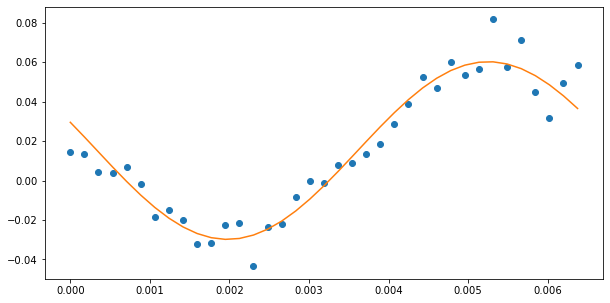

particle is:1
933.7144060432402
Storage modulus is:153.79334204860146
Loss modulus is:45.15221768429212
R^2: 0.907633435183331
[ 0.05513614  2.85602674 -0.04295329]


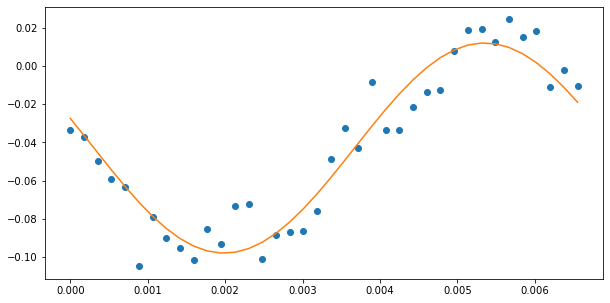

particle is:17
933.7144060432402
Storage modulus is:181.50182032428728
Loss modulus is:82.57560582334328
R^2: 0.8533248473156945
[ 0.04431958  2.71462376 -0.09999997]


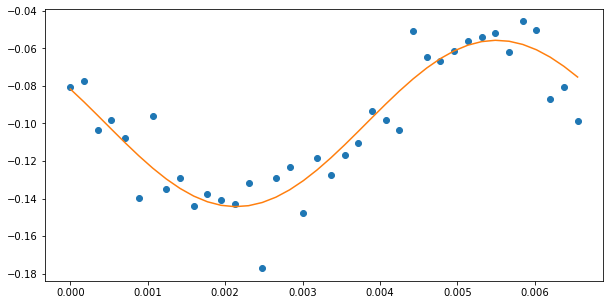

particle is:19
1182.7049143214374
Storage modulus is:210.39303125011878
Loss modulus is:11.063138066228227
R^2: 0.8214473119439544
[0.04194661 3.08905784 0.00357441]


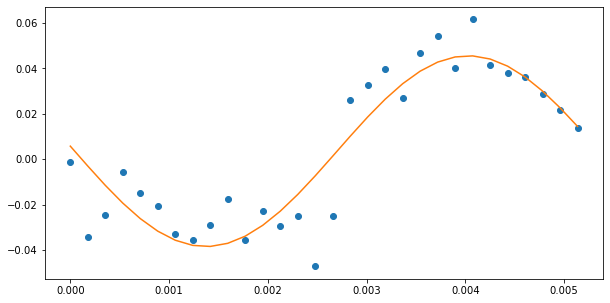

particle is:21
545.8638066098943
Storage modulus is:367.38276759221066
Loss modulus is:980.6002577725311
R^2: 0.011968500803047233
[ 0.00843945  1.9292609  -0.01992976]


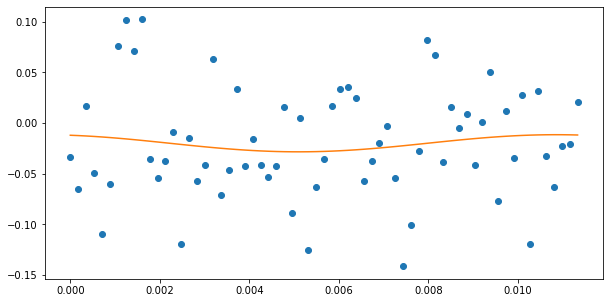

particle is:26
933.7144060432402
Storage modulus is:287.3723721955983
Loss modulus is:55.62861088509225
R^2: 0.8081079199469666
[ 0.03019219  2.95038085 -0.00680367]


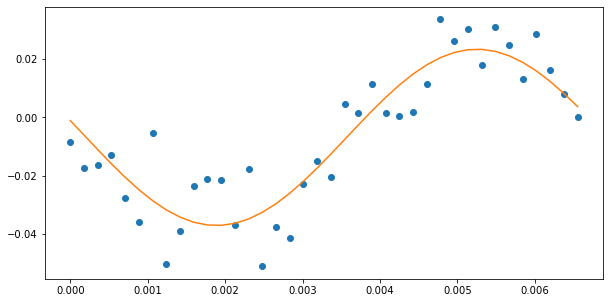

particle is:28
958.9499305308952
Storage modulus is:-6358.620575711487
Loss modulus is:6.144613481968251e-07
R^2: 0.0004731278969745123
[1.38984031e-03 9.66344620e-11 1.92589823e-02]


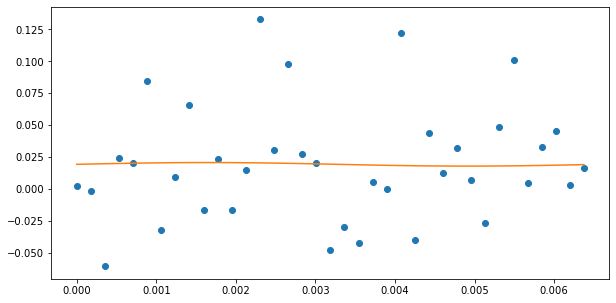

particle is:33
933.7144060432402
Storage modulus is:441.80172939474
Loss modulus is:1.9619938091730127e-13
R^2: 0.031167197736497232
[0.02000324 3.14159265 0.05725166]


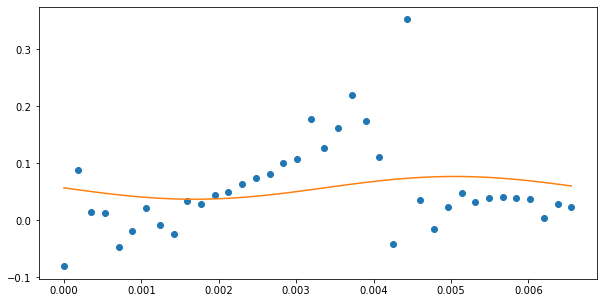

particle is:35
933.7144060432402
Storage modulus is:220.7181961465672
Loss modulus is:10.280131711620989
R^2: 0.8451765983290558
[0.03999624 3.09505047 0.00845639]


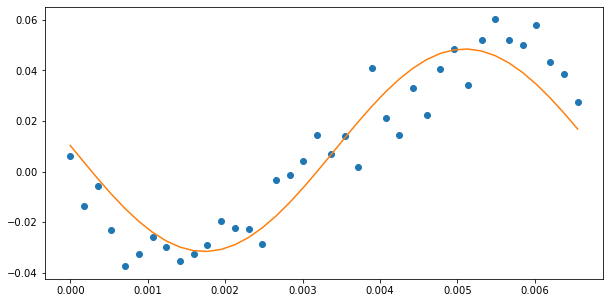

particle is:36
933.7144060432402
Storage modulus is:-580.4824937548891
Loss modulus is:7.108860279379983e-14
R^2: 0.035537180145537195
[1.52243475e-02 1.96043421e-22 4.38675389e-02]


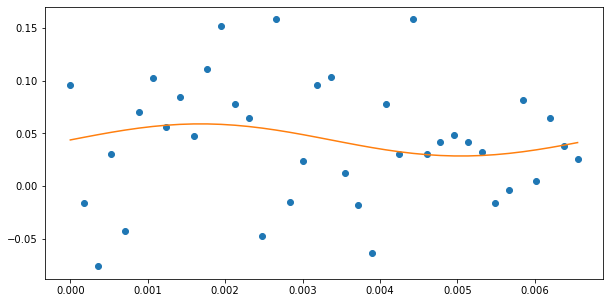

particle is:37
985.5874286011978
Storage modulus is:205.0617883264867
Loss modulus is:28.726713977393462
R^2: 0.05886164474274724
[0.04267985 3.00241032 0.1       ]


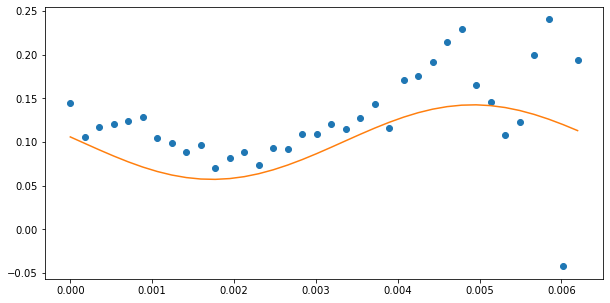

particle is:38
933.7144060432402
Storage modulus is:202.99057957860225
Loss modulus is:50.512868074478824
R^2: 0.8595918644955645
[0.04224793 2.89770284 0.01310821]


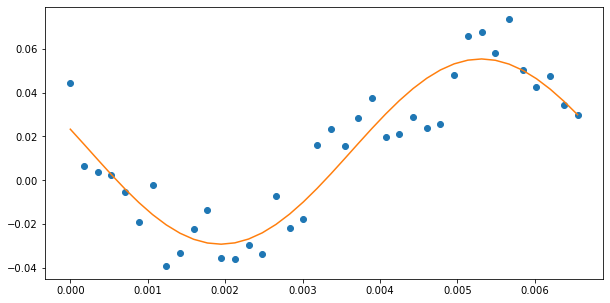

particle is:39
933.7144060432402
Storage modulus is:249.8105975173343
Loss modulus is:40.44610829828457
R^2: 0.8473896151489703
[0.03492191 2.98107845 0.00538646]


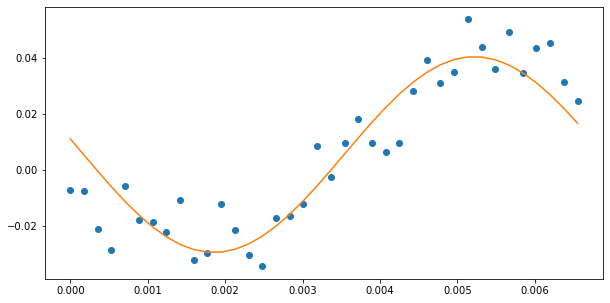

particle is:46
933.7144060432402
Storage modulus is:684.1271013246317
Loss modulus is:3.038134638642694e-13
R^2: 0.025355087012995936
[ 0.01291787  3.14159265 -0.00786373]


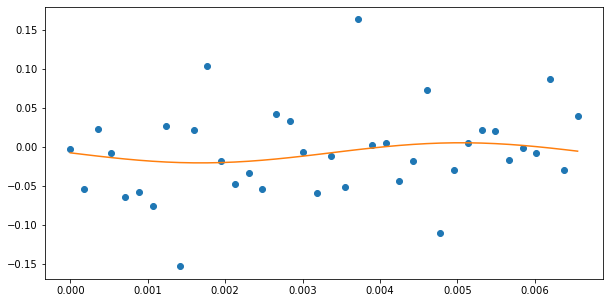

particle is:50
933.7144060432402
Storage modulus is:266.91431750478756
Loss modulus is:67.23201829431018
R^2: 0.7995313097762742
[3.21068792e-02 2.89483959e+00 6.61157610e-04]


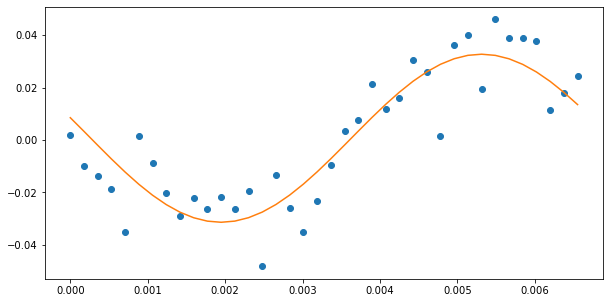

particle is:54
933.7144060432402
Storage modulus is:286.2589382825651
Loss modulus is:61.551659002299445
R^2: 0.799424088862465
[0.03018244 2.9297965  0.00469514]


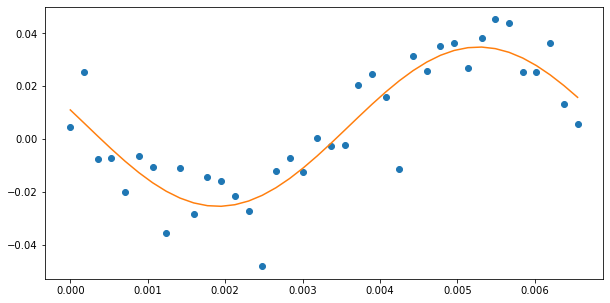

particle is:55
958.9499305308952
Storage modulus is:306.1655950815207
Loss modulus is:72.30702875830275
R^2: 0.8390519314723158
[0.02809218 2.90967252 0.00630077]


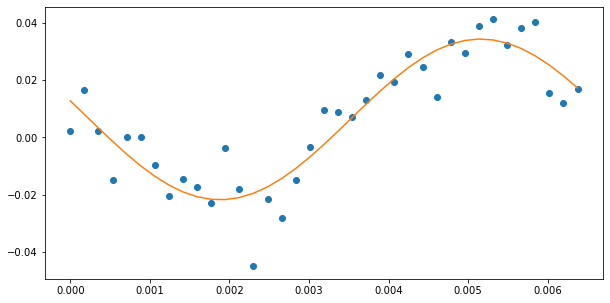

particle is:57
958.9499305308952
Storage modulus is:179.0069131739654
Loss modulus is:95.7422310509203
R^2: 0.3566617890568339
[ 0.04353377  2.65045361 -0.1       ]


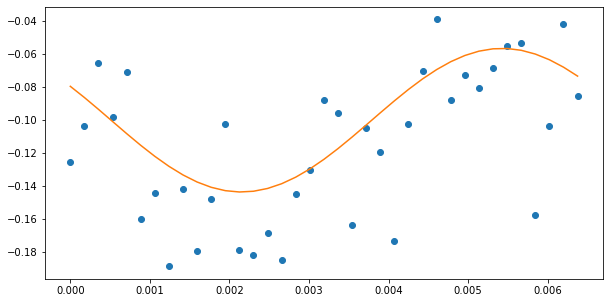

particle is:58
958.9499305308952
Storage modulus is:147.6709071295832
Loss modulus is:56.426561767423905
R^2: 0.776971742368133
[0.0559035  2.77660299 0.04378123]


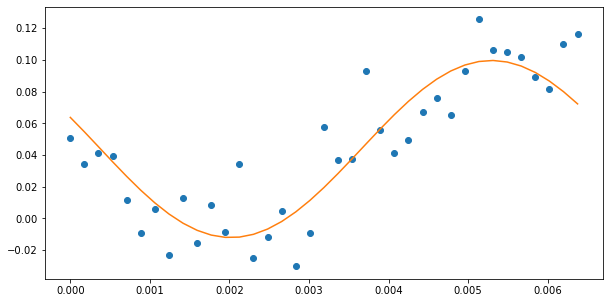

particle is:60
958.9499305308952
Storage modulus is:254.86187341529637
Loss modulus is:28.84163497555931
R^2: 0.843294751464796
[0.03445559 3.02890631 0.00868747]


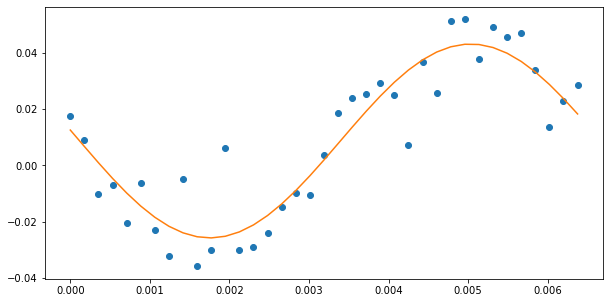

particle is:62
958.9499305308952
Storage modulus is:203.6545176205931
Loss modulus is:60.3943871331833
R^2: 0.8572721872513246
[0.04160356 2.85330111 0.01389076]


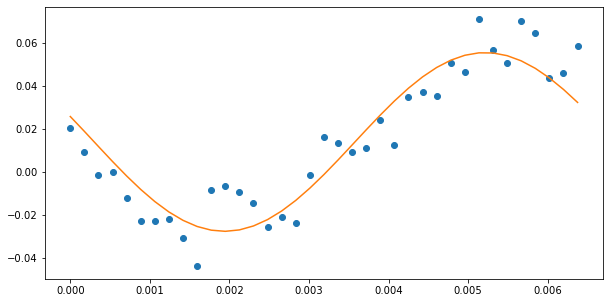

particle is:63
933.7144060432402
Storage modulus is:243.59469134916398
Loss modulus is:38.888306055682875
R^2: 0.8074570621990498
[3.58257357e-02 2.98328502e+00 1.60410497e-03]


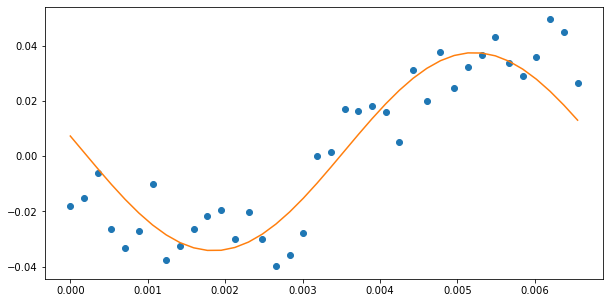

particle is:64
657.0582857341319
Storage modulus is:-168.89856405645628
Loss modulus is:216.33346501261363
R^2: 0.15281795737393322
[ 0.03219977  0.90791478 -0.01893646]


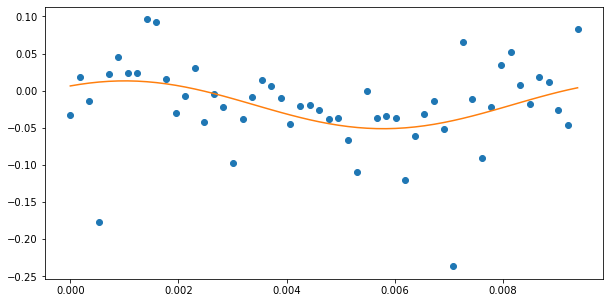

particle is:65
958.9499305308952
Storage modulus is:186.54221845523458
Loss modulus is:96.54151370153771
R^2: 0.9255820478178407
[0.04207447 2.66401825 0.01324167]


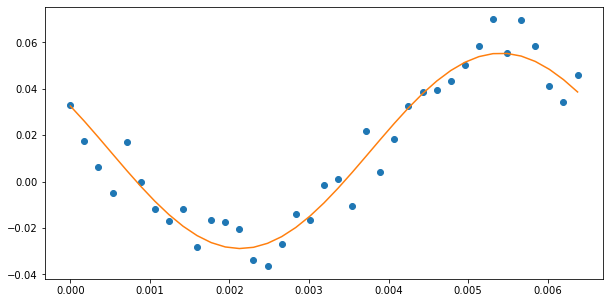

particle is:67
1043.563159695386
Storage modulus is:176.87597572078786
Loss modulus is:17.752864065846612
R^2: 0.9063331302674309
[0.04971442 3.04155867 0.01239073]


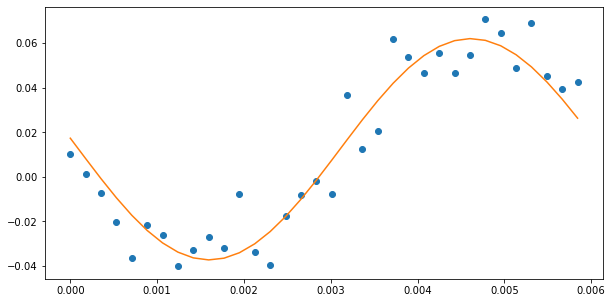

particle is:69
958.9499305308952
Storage modulus is:1951.7714540706052
Loss modulus is:8.667606428461228e-13
R^2: 0.053685422280507544
[ 0.00452792  3.14159265 -0.0272655 ]


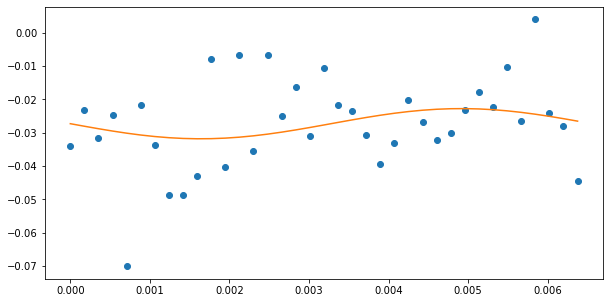

particle is:70
909.7730110164904
Storage modulus is:-85.95282509107727
Loss modulus is:1.0526185212546008e-14
R^2: 0.31714004328192735
[ 1.02817646e-01  7.67222943e-20 -4.58553319e-02]


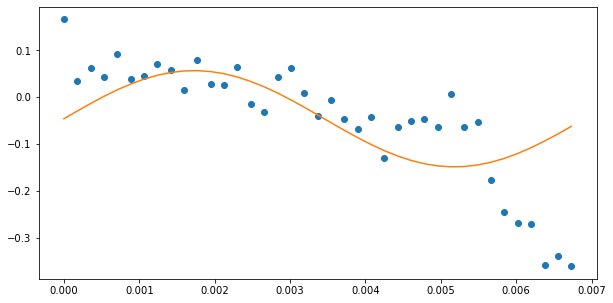

particle is:71
958.9499305308952
Storage modulus is:284.8552556084992
Loss modulus is:77.84333983189376
R^2: 0.8152647703054817
[2.99270794e-02 2.87483244e+00 2.16715360e-03]


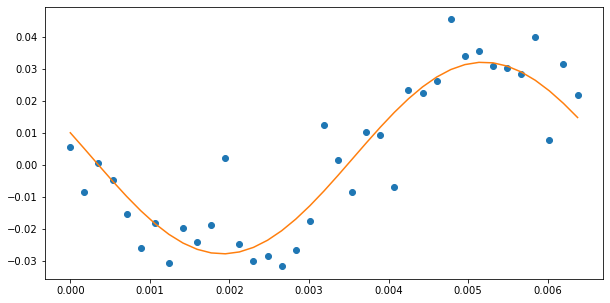

particle is:72
958.9499305308952
Storage modulus is:35.24496150303081
Loss modulus is:157.67636652886156
R^2: 0.9255617869988308
[ 0.05469831  1.79070852 -0.02485724]


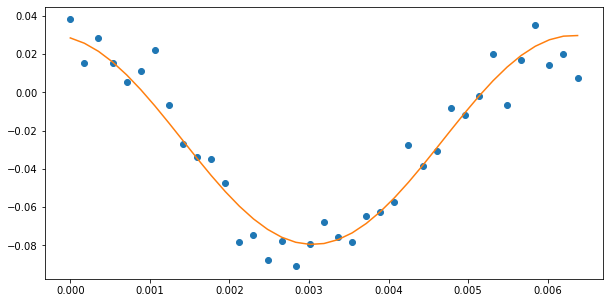

particle is:73
933.7144060432402
Storage modulus is:187.3420526711363
Loss modulus is:90.69710499997285
R^2: 0.8831287730887947
[0.04245888 2.69072493 0.01109551]


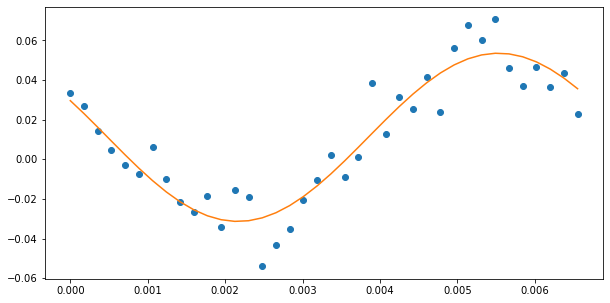

particle is:74
958.9499305308952
Storage modulus is:249.8801638670329
Loss modulus is:51.646349412865426
R^2: 0.8529711147539701
[0.03463479 2.93777806 0.01112865]


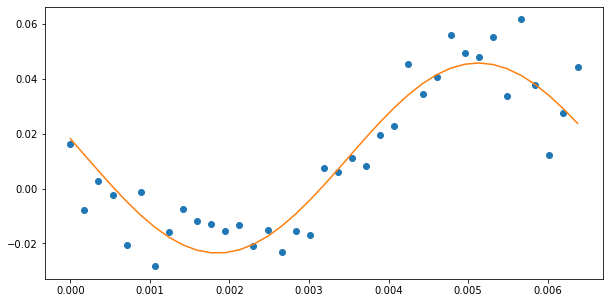

particle is:75
958.9499305308952
Storage modulus is:267.5814579092531
Loss modulus is:27.36935309492749
R^2: 0.8271324334736071
[3.28557809e-02 3.03966294e+00 2.14139061e-03]


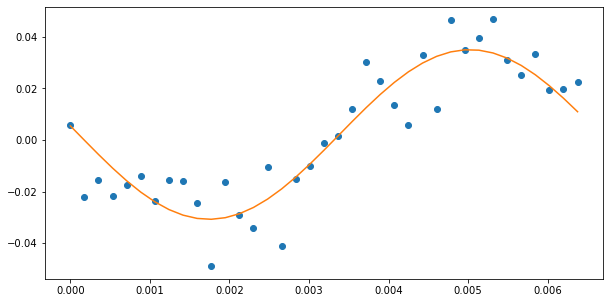

particle is:76
933.7144060432402
Storage modulus is:139.69170274818765
Loss modulus is:66.00621015160218
R^2: 0.9506242707940249
[ 0.05720003  2.70017506 -0.01055606]


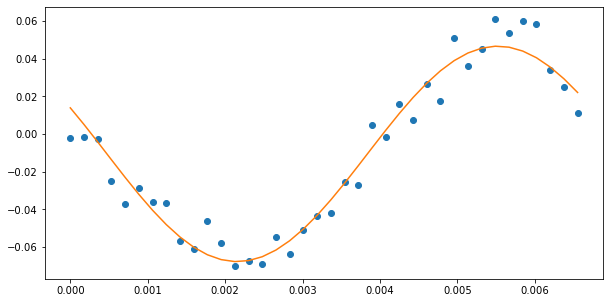

particle is:77
933.7144060432402
Storage modulus is:306.45335399764156
Loss modulus is:52.35891003345523
R^2: 0.7534657724939651
[ 0.02842598  2.97237219 -0.00338378]


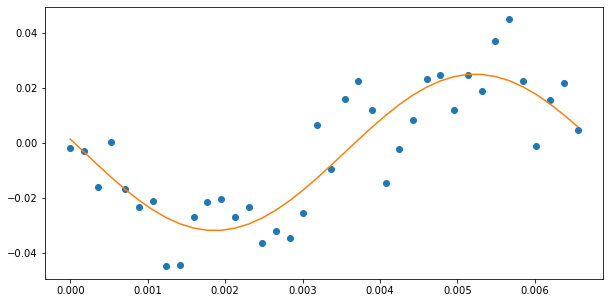

particle is:78
1364.6595165247354
Storage modulus is:68.75968483641694
Loss modulus is:586.3234571494866
R^2: 0.04370184915505748
[0.01497009 1.68753572 0.02807192]


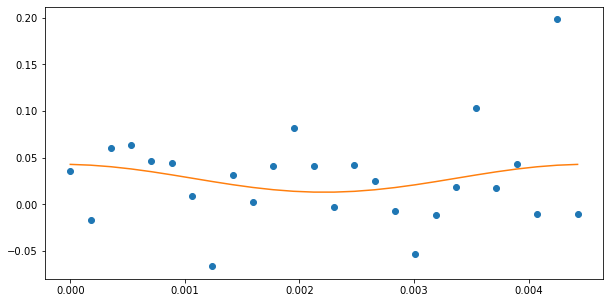

particle is:79
958.9499305308952
Storage modulus is:276.3236594886123
Loss modulus is:74.38164055616947
R^2: 0.8091194906338717
[0.03088299 2.87864243 0.00703322]


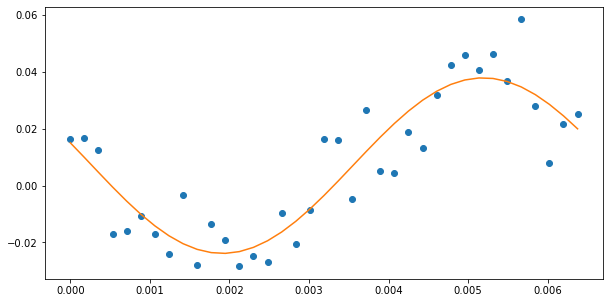

particle is:80
933.7144060432402
Storage modulus is:168.25334732113478
Loss modulus is:77.50946340487603
R^2: 0.9452618224742045
[ 0.04770608  2.70990012 -0.00779224]


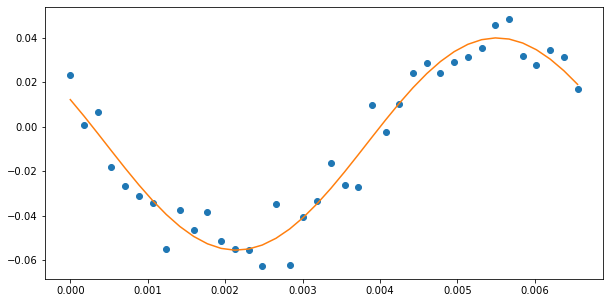

particle is:81
958.9499305308952
Storage modulus is:242.70381596393068
Loss modulus is:52.75880060565713
R^2: 0.8264072348736146
[3.55815808e-02 2.92754337e+00 8.96559914e-04]


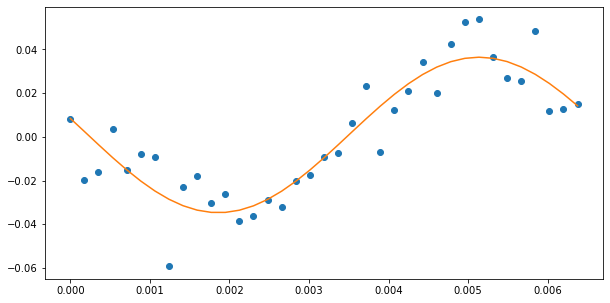

particle is:82
958.9499305308952
Storage modulus is:253.94981893133618
Loss modulus is:55.89710112562575
R^2: 0.7850755105832004
[0.03398649 2.92493665 0.00372914]


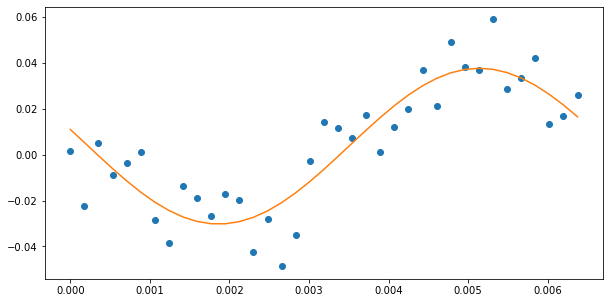

particle is:88
958.9499305308952
Storage modulus is:195.36898310705752
Loss modulus is:81.97496556095842
R^2: 0.8192754789495248
[0.04171173 2.74431283 0.00290833]


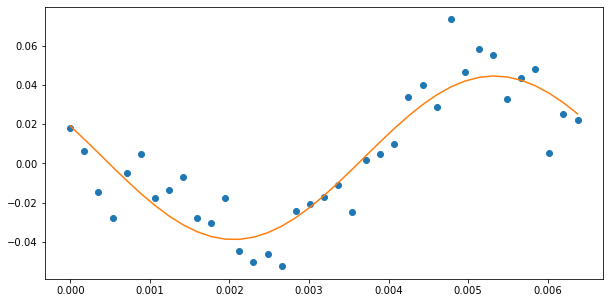

particle is:90
933.7144060432402
Storage modulus is:278.60071624952354
Loss modulus is:48.76250369664935
R^2: 0.8029837018758089
[3.12459185e-02 2.96832129e+00 1.93040314e-03]


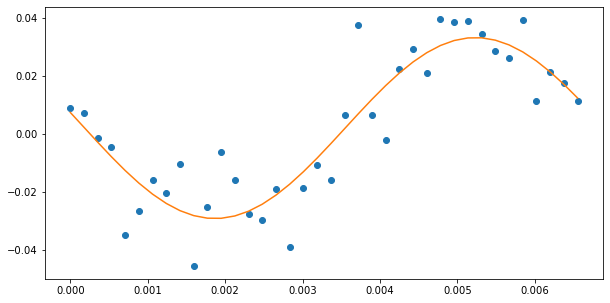

particle is:94
933.7144060432402
Storage modulus is:239.6074695726634
Loss modulus is:90.9333594330434
R^2: 0.8129629290567737
[ 3.44833307e-02  2.77887415e+00 -7.38968149e-04]


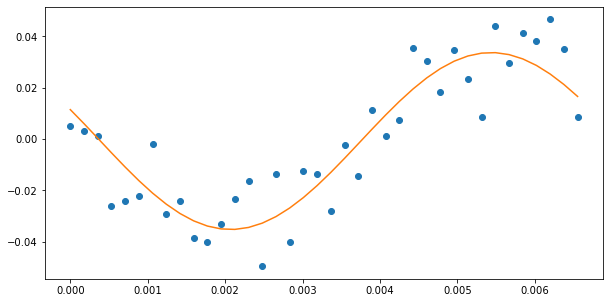

In [36]:
data1=utils.analyze_wavelength_modulus(wavelength1,gamma2list_w1,real_stress,framerate,imgname)

In [37]:
data1

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
0,0,186.213985,62.371988,958.949931,0.927169,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
1,1,153.793342,45.152218,933.714406,0.907633,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
2,17,181.501820,82.575606,933.714406,0.853325,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
3,19,210.393031,11.063138,1182.704914,0.821447,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
5,26,287.372372,55.628611,933.714406,0.808108,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
8,35,220.718196,10.280132,933.714406,0.845177,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
11,38,202.990580,50.512868,933.714406,0.859592,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
12,39,249.810598,40.446108,933.714406,0.847390,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
14,50,266.914318,67.232018,933.714406,0.799531,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
15,54,286.258938,61.551659,933.714406,0.799424,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...


In [40]:
data1 = data1[data1['Droplet Number'] != 72]

## wavelegnth 2

In [41]:
wavelength2=t1_modified[(t1_modified['x'] >= 563) & (t1_modified['x'] <= 876)]

In [42]:
gamma2list_w2=utils.analyze_wavelength_gamma2(wavelength2,2,imgname,img_tif,ref)

particle number: 0
frame number is39
frame number is40


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is41
frame number is42
frame number is43
frame number is44
frame number is45
frame number is46
frame number is47
frame number is48
frame number is49
frame number is50
frame number is51
frame number is52


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is53
frame number is54
frame number is55
frame number is56
frame number is57
frame number is58
frame number is59
frame number is60
frame number is61
frame number is62
frame number is63
frame number is64
frame number is65
frame number is66
frame number is67
frame number is68


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is69
frame number is70


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is71
frame number is72


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is73
frame number is74
frame number is75
frame number is76


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is77
frame number is78


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is79
frame number is80
frame number is81
particle number: 1
frame number is295
frame number is296
frame number is297
frame number is298
frame number is299
frame number is300
frame number is301
frame number is302
frame number is303
frame number is304
frame number is305
frame number is306
frame number is307
frame number is308
frame number is309
frame number is310
frame number is311
frame number is312
frame number is313
frame number is314
frame number is315


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is316
frame number is317
frame number is318
frame number is319


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is320
frame number is321
frame number is322
frame number is323
frame number is324
frame number is325
frame number is326
frame number is327
frame number is328
frame number is329


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is330
frame number is331
frame number is332
frame number is333
frame number is334
frame number is335


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is336
frame number is337
particle number: 17
frame number is409
frame number is410


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is411
frame number is412
frame number is413
frame number is414
frame number is415
frame number is416
frame number is417
frame number is418


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is419
frame number is420


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is421
frame number is422
frame number is423
frame number is424


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is425
frame number is426


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is427
frame number is428
frame number is429
frame number is430
frame number is431
frame number is432


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is433
frame number is434


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is435
frame number is436


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is437
frame number is438
frame number is439
frame number is440
frame number is441
frame number is442


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is443
frame number is444
frame number is445
frame number is446
frame number is447
frame number is448
frame number is449
frame number is450
frame number is451
particle number: 19
frame number is417


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is418
frame number is419
frame number is420
frame number is421
frame number is422
frame number is423
frame number is424
frame number is425
frame number is426
frame number is427
frame number is428
frame number is429
frame number is430
frame number is431
frame number is432
frame number is433
frame number is434
frame number is435


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is436
frame number is437
frame number is438
frame number is439
frame number is440
frame number is441
frame number is442
frame number is443
frame number is444
frame number is445
frame number is446
frame number is447
frame number is448
frame number is449
frame number is450
frame number is451
frame number is452
frame number is453
frame number is454
frame number is455
frame number is456
frame number is457
frame number is458
frame number is459
particle number: 21
frame number is733
frame number is734


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is735
frame number is736
frame number is737
frame number is738


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is739
frame number is740


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is741
frame number is742


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is743
frame number is744


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is745
frame number is746


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is747
frame number is748


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is749


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is750
frame number is751


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is752
frame number is753


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is754
frame number is755
frame number is756
frame number is757


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is758
frame number is759


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is760
frame number is761


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is762
frame number is763


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is764
frame number is765


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is766
frame number is767


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is768
frame number is769


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is770
frame number is771


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is772
frame number is773


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is774
frame number is775
frame number is776
frame number is777


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is778
frame number is779
frame number is780
frame number is781


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is782
frame number is783


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is784
frame number is785
frame number is786
frame number is787


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is788
frame number is789


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is790
frame number is791


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is792
frame number is793


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is794
frame number is795


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is796
frame number is797


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is798
frame number is799


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is800
frame number is801


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is802
frame number is803


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is804


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is805
frame number is806


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 26
frame number is1064
frame number is1065
frame number is1066
frame number is1067
frame number is1068
frame number is1069


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1070
frame number is1071
frame number is1072
frame number is1073


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1074
frame number is1075


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1076
frame number is1077
frame number is1078
frame number is1079
frame number is1080
frame number is1081
frame number is1082
frame number is1083


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1084
frame number is1085
frame number is1086
frame number is1087


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1088
frame number is1089
frame number is1090
frame number is1091
frame number is1092
particle number: 28
frame number is1109
frame number is1110
frame number is1111


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1112
frame number is1113


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1114
frame number is1115
frame number is1116
frame number is1117


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1118
frame number is1119


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1120
frame number is1121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1122
frame number is1123


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1124
frame number is1125


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1126
frame number is1127


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1128
frame number is1129
frame number is1130
frame number is1131


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1132
frame number is1133
frame number is1134


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1135
frame number is1136


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1137
frame number is1138


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1139
frame number is1140
frame number is1141
frame number is1142


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1143
frame number is1144


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1145
frame number is1146


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1147
frame number is1148
frame number is1149


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 33
frame number is1500
frame number is1501
frame number is1502
frame number is1503
frame number is1504
frame number is1505
frame number is1506
frame number is1507
frame number is1508
frame number is1509


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1510
frame number is1511
frame number is1512
frame number is1513
frame number is1514
frame number is1515
frame number is1516
frame number is1517
frame number is1518
frame number is1519
frame number is1520
frame number is1521
frame number is1522
frame number is1523
frame number is1524
frame number is1525
frame number is1526
frame number is1527
frame number is1528
frame number is1529
frame number is1530
frame number is1531
frame number is1532
frame number is1533
frame number is1534
frame number is1535
frame number is1536
frame number is1537
frame number is1538
frame number is1539


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1540
frame number is1541
frame number is1542
particle number: 35
frame number is1542
frame number is1543
frame number is1544
frame number is1545
frame number is1546
frame number is1547
frame number is1548
frame number is1549
frame number is1550
frame number is1551
frame number is1552
frame number is1553
frame number is1554
frame number is1555
frame number is1556
frame number is1557
frame number is1558
frame number is1559
frame number is1560


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1561
frame number is1562
frame number is1563
frame number is1564
frame number is1565
frame number is1566
frame number is1567
frame number is1568
frame number is1569
frame number is1570
frame number is1571
frame number is1572


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1573
frame number is1574
frame number is1575
frame number is1576


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1577
frame number is1578
frame number is1579
frame number is1580
frame number is1581
frame number is1582
frame number is1583
frame number is1584
particle number: 36
frame number is2009
frame number is2011
frame number is2012
frame number is2013


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2014
frame number is2015


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2016
frame number is2017


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2018
frame number is2019


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2020
frame number is2021


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2022
frame number is2023


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2024
frame number is2025


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2026
frame number is2027
frame number is2028
frame number is2029


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2030
frame number is2031
frame number is2032
frame number is2033


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2034
frame number is2035
frame number is2036
frame number is2037


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2038
frame number is2039


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2040
frame number is2041


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2042
frame number is2043
frame number is2044
frame number is2045
frame number is2046
frame number is2047


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2048
frame number is2049
frame number is2050
frame number is2051


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 37
frame number is2147
frame number is2148
frame number is2149
frame number is2150


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2151
frame number is2152


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2153
frame number is2154
frame number is2155
frame number is2156


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2157
frame number is2158
frame number is2159
frame number is2160
frame number is2161
frame number is2162
frame number is2163
frame number is2164


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2165
frame number is2166


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2167
frame number is2168
frame number is2169
frame number is2170


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2171
frame number is2172
frame number is2173
frame number is2174
frame number is2175
frame number is2176


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2177
frame number is2178
frame number is2179
frame number is2180
frame number is2181
frame number is2182


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2183
frame number is2184
frame number is2185
frame number is2186
frame number is2187
particle number: 38
frame number is2334


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2335
frame number is2336
frame number is2337
frame number is2338


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2339
frame number is2340
frame number is2341
frame number is2342
frame number is2343
frame number is2344
frame number is2345
frame number is2346
frame number is2347
frame number is2348
frame number is2349
frame number is2350
frame number is2351
frame number is2352


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2353
frame number is2354


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2355
frame number is2356
frame number is2357
frame number is2358
frame number is2359
frame number is2360
frame number is2361
frame number is2362
frame number is2363
frame number is2364
frame number is2365
frame number is2366
frame number is2367
frame number is2368


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2369
frame number is2370
frame number is2371
frame number is2372
frame number is2373


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2374
frame number is2375
frame number is2376
particle number: 39
frame number is2683


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2684
frame number is2685
frame number is2686
frame number is2687
frame number is2688
frame number is2689
frame number is2690
frame number is2691
frame number is2692
frame number is2693
frame number is2694
frame number is2695
frame number is2696
frame number is2697
frame number is2698
frame number is2699
frame number is2700
frame number is2701
frame number is2702
frame number is2703
frame number is2704
frame number is2705
frame number is2706
frame number is2707
frame number is2708
frame number is2709
frame number is2710
frame number is2711
frame number is2712
frame number is2713


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2714
frame number is2715


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2716
frame number is2717
frame number is2718
frame number is2719
frame number is2720
frame number is2721
frame number is2722
frame number is2723


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2724
particle number: 46
frame number is2731


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2732
frame number is2733


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2734
frame number is2735


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2736
frame number is2737
frame number is2738
frame number is2739


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2740
frame number is2741


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2742
frame number is2743


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2744
frame number is2745


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2746
frame number is2747


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2748
frame number is2749


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2750
frame number is2751


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2752
frame number is2753


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2754
frame number is2755


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2756
frame number is2757


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2758
frame number is2759


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2760
frame number is2761
frame number is2762
frame number is2763


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2764
frame number is2765


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2766
frame number is2767


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2768
frame number is2769


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2770
frame number is2771


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2772
particle number: 50
frame number is2796
frame number is2797
frame number is2798
frame number is2799
frame number is2800
frame number is2801
frame number is2802


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2803
frame number is2804
frame number is2805
frame number is2806
frame number is2807
frame number is2808
frame number is2809
frame number is2810


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2811
frame number is2812
frame number is2813
frame number is2814


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2815
frame number is2816
frame number is2817
frame number is2818


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2819
frame number is2820
frame number is2821
frame number is2822
frame number is2823
frame number is2824
frame number is2825
frame number is2826
frame number is2827
frame number is2828
frame number is2829
frame number is2830
frame number is2831
frame number is2832
frame number is2833
frame number is2834


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2835
frame number is2836


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2837
frame number is2838


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 54
frame number is2863
frame number is2864
frame number is2865
frame number is2866


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2867
frame number is2868
frame number is2869
frame number is2870
frame number is2871
frame number is2872
frame number is2873
frame number is2874
frame number is2875
frame number is2876
frame number is2877
frame number is2878
frame number is2879
frame number is2880
frame number is2881
frame number is2882


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2883
frame number is2884
frame number is2885
frame number is2886
frame number is2887
frame number is2888
frame number is2889
frame number is2890


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2891
frame number is2892
frame number is2893
frame number is2894
frame number is2895
frame number is2896


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2897
frame number is2898
frame number is2899
frame number is2900
frame number is2901
frame number is2902
frame number is2903
frame number is2904


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 55
frame number is2877
frame number is2878
frame number is2879
frame number is2880
frame number is2881
frame number is2882
frame number is2883
frame number is2884
frame number is2885
frame number is2886
frame number is2887
frame number is2888
frame number is2889
frame number is2890
frame number is2891
frame number is2892


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2893
frame number is2894
frame number is2895
frame number is2896
frame number is2897
frame number is2898
frame number is2899
frame number is2900
frame number is2901
frame number is2902


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2903
frame number is2904


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2905
frame number is2906
frame number is2907
frame number is2908
frame number is2909
frame number is2910
frame number is2911
frame number is2912
frame number is2913
frame number is2914
frame number is2915
frame number is2916
frame number is2917
frame number is2918


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2919
particle number: 57
frame number is2903
frame number is2904
frame number is2905


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2906
frame number is2907


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2908
frame number is2909


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2910
frame number is2911
frame number is2912
frame number is2913
frame number is2914
frame number is2915
frame number is2916
frame number is2917
frame number is2918
frame number is2919
frame number is2920
frame number is2921
frame number is2922
frame number is2923
frame number is2924
frame number is2925
frame number is2926
frame number is2927


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2928
frame number is2929
frame number is2930
frame number is2931
frame number is2932
frame number is2933


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2934
frame number is2935


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2936
frame number is2937
frame number is2938
frame number is2939
frame number is2940
frame number is2941
frame number is2942
frame number is2943


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 58
frame number is3032
frame number is3033


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3034
frame number is3035


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3036
frame number is3037
frame number is3038
frame number is3039
frame number is3040
frame number is3041
frame number is3042
frame number is3044


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3045
frame number is3046
frame number is3049
frame number is3051


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3056
frame number is3057
frame number is3058
frame number is3059
frame number is3060
frame number is3061
frame number is3062
frame number is3063


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3064
frame number is3065
frame number is3066
frame number is3067


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3068
frame number is3069
frame number is3070
frame number is3071


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3072
frame number is3073
particle number: 60
frame number is3326
frame number is3327
frame number is3328
frame number is3329
frame number is3330
frame number is3331
frame number is3332
frame number is3333
frame number is3334
frame number is3335


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3336
frame number is3337
frame number is3338
frame number is3339
frame number is3340
frame number is3341
frame number is3342
frame number is3343
frame number is3344
frame number is3345


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3346
frame number is3347


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3348
frame number is3349
frame number is3350
frame number is3351
frame number is3352
frame number is3353


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3354
frame number is3355
frame number is3356


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3357
frame number is3358


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3359
frame number is3360
frame number is3361
frame number is3362


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3363
frame number is3364
frame number is3365
frame number is3366
frame number is3367
frame number is3368
particle number: 62
frame number is3713
frame number is3714
frame number is3715
frame number is3716


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3717
frame number is3718
frame number is3719
frame number is3720
frame number is3721
frame number is3722


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3723
frame number is3724
frame number is3725
frame number is3726
frame number is3727
frame number is3728
frame number is3729
frame number is3730
frame number is3731
frame number is3732


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3733
frame number is3734
frame number is3735
frame number is3736
frame number is3737
frame number is3738


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3739
frame number is3740
frame number is3741
frame number is3742
frame number is3743
frame number is3744
frame number is3745
frame number is3746
frame number is3747
frame number is3748


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3749
frame number is3750
frame number is3751
frame number is3752
frame number is3753
frame number is3754


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3755
particle number: 63
frame number is4079
frame number is4080
frame number is4081


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4082
frame number is4083
frame number is4084
frame number is4085
frame number is4086
frame number is4087
frame number is4088
frame number is4089
frame number is4090
frame number is4091


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4092
frame number is4093


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4094
frame number is4095
frame number is4096
frame number is4097
frame number is4098
frame number is4099
frame number is4100
frame number is4101
frame number is4102
frame number is4103
frame number is4104
frame number is4105
frame number is4106
frame number is4107
frame number is4108
frame number is4109
frame number is4110
frame number is4111
frame number is4112
frame number is4113


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4114
frame number is4115
frame number is4116
frame number is4117
frame number is4118
frame number is4119
frame number is4120
particle number: 64
frame number is4336


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4337
frame number is4338


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4339
frame number is4340
frame number is4341
frame number is4342
frame number is4343
frame number is4344


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4345
frame number is4346
frame number is4347
frame number is4348


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4349
frame number is4350


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4351
frame number is4352
frame number is4353
frame number is4354
frame number is4355
frame number is4356


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4357
frame number is4358


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4359
frame number is4360
frame number is4361
frame number is4362


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4363
frame number is4364


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4365
frame number is4366


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4367
frame number is4368


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4369
frame number is4370
frame number is4371
frame number is4372


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4373
frame number is4374


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4375
frame number is4376


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4377
frame number is4378
frame number is4379
frame number is4380


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4381
frame number is4382
frame number is4383
frame number is4384
frame number is4385
frame number is4386


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4387
frame number is4388
frame number is4389
frame number is4390


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4391
frame number is4392


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4393
frame number is4394


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4395
frame number is4396


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4397
particle number: 65
frame number is4409
frame number is4410
frame number is4411
frame number is4412
frame number is4413
frame number is4414
frame number is4415
frame number is4416
frame number is4417
frame number is4418
frame number is4419
frame number is4420
frame number is4421
frame number is4422
frame number is4423
frame number is4424
frame number is4425


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4426
frame number is4427
frame number is4428
frame number is4429
frame number is4430
frame number is4431
frame number is4432
frame number is4433
frame number is4434
frame number is4435
frame number is4436
frame number is4437
frame number is4438
frame number is4439
frame number is4440
frame number is4441


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4442
frame number is4443
frame number is4444
frame number is4445
frame number is4446
frame number is4447


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4448
frame number is4449
frame number is4450
frame number is4451
particle number: 67
frame number is4471
frame number is4472
frame number is4473
frame number is4474
frame number is4475
frame number is4476
frame number is4477
frame number is4478


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4479
frame number is4480
frame number is4481
frame number is4482
frame number is4483
frame number is4484
frame number is4485
frame number is4486
frame number is4487
frame number is4488
frame number is4489
frame number is4490
frame number is4491
frame number is4492


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4493
frame number is4494
frame number is4495
frame number is4496
frame number is4497
frame number is4498
frame number is4499
frame number is4500
frame number is4501
frame number is4502
frame number is4503
frame number is4504
frame number is4505
frame number is4506


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4507
frame number is4508
frame number is4509
frame number is4510
frame number is4511
frame number is4512
frame number is4513
particle number: 69
frame number is4494


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4495
frame number is4496
frame number is4497
frame number is4498


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4499
frame number is4500


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4501
frame number is4502


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4503
frame number is4504


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4505
frame number is4506
frame number is4507
frame number is4508


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4509
frame number is4510


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4511
frame number is4512


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4513
frame number is4514


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4515
frame number is4516


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4517
frame number is4518


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4519
frame number is4520
frame number is4521
frame number is4522


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4523
frame number is4524


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4525
frame number is4526


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4527
frame number is4528


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4529
frame number is4530


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4531
frame number is4532


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4533
frame number is4534


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4535
frame number is4536


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 70
frame number is4871
frame number is4872


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4873
frame number is4874


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4875
frame number is4876


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4877
frame number is4878
frame number is4879
frame number is4880


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4881
frame number is4882


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4883
frame number is4884


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4885
frame number is4886


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4887
frame number is4888
frame number is4889
frame number is4890


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4891
frame number is4892


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4893
frame number is4894
frame number is4895
frame number is4896


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4897
frame number is4898


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4899
frame number is4900
frame number is4901
frame number is4902


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4903
frame number is4904


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4905
frame number is4906


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4907
frame number is4908


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4909
frame number is4910


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4911
frame number is4912


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4913
frame number is4914


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


particle number: 71
frame number is5009
frame number is5010


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5011
frame number is5012
frame number is5013
frame number is5014


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5015
frame number is5016


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5017
frame number is5018


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5019
frame number is5020
frame number is5021
frame number is5022
frame number is5023
frame number is5024


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5025
frame number is5026
frame number is5027
frame number is5028
frame number is5029
frame number is5030
frame number is5031
frame number is5032
frame number is5033
frame number is5034
frame number is5035
frame number is5036


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5037
frame number is5038
frame number is5039
frame number is5040
frame number is5041
frame number is5042
frame number is5043
frame number is5044


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5045
frame number is5046
frame number is5047
frame number is5048


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5049
frame number is5050
frame number is5051
particle number: 72
frame number is5067
frame number is5068
frame number is5069


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5070
frame number is5071
frame number is5072
frame number is5073
frame number is5074
frame number is5075
frame number is5076
frame number is5077
frame number is5078
frame number is5079
frame number is5080
frame number is5081
frame number is5082
frame number is5083


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5084
frame number is5085


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5086
frame number is5087
frame number is5088
frame number is5089
frame number is5090
frame number is5091
frame number is5092
frame number is5093
frame number is5094
frame number is5095


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5096
frame number is5097


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5098
frame number is5099
frame number is5100
frame number is5101
frame number is5102
frame number is5103


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5104
frame number is5105
frame number is5106
frame number is5107
particle number: 73
frame number is5108
frame number is5109


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5110
frame number is5111
frame number is5112
frame number is5113


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5114
frame number is5115
frame number is5116
frame number is5117
frame number is5118
frame number is5119
frame number is5120
frame number is5121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5122
frame number is5123
frame number is5124
frame number is5125
frame number is5126
frame number is5127
frame number is5128
frame number is5129
frame number is5130
frame number is5131
frame number is5132
frame number is5133
frame number is5134
frame number is5135
frame number is5136
frame number is5137
frame number is5138
frame number is5139
frame number is5140
frame number is5141
frame number is5142
frame number is5143


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5144
frame number is5145
frame number is5146
frame number is5147


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5148
frame number is5149
frame number is5150
particle number: 74
frame number is5124
frame number is5125
frame number is5126
frame number is5127
frame number is5128
frame number is5129
frame number is5130
frame number is5131
frame number is5132
frame number is5133
frame number is5134
frame number is5135
frame number is5136


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5137
frame number is5138
frame number is5139
frame number is5140
frame number is5141
frame number is5142
frame number is5143
frame number is5144
frame number is5145
frame number is5146
frame number is5147
frame number is5148


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5149
frame number is5150
frame number is5151
frame number is5152


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5153
frame number is5154
frame number is5155
frame number is5156


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5157
frame number is5158
frame number is5159
frame number is5160


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5161
frame number is5162


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5163
frame number is5164
frame number is5165
frame number is5166


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 75
frame number is5147
frame number is5148
frame number is5149
frame number is5150
frame number is5151
frame number is5152
frame number is5153
frame number is5154
frame number is5155
frame number is5156
frame number is5157
frame number is5158
frame number is5159
frame number is5160
frame number is5161
frame number is5162
frame number is5163
frame number is5164
frame number is5165
frame number is5166


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5167
frame number is5168
frame number is5169
frame number is5170
frame number is5171
frame number is5172
frame number is5173
frame number is5174
frame number is5175
frame number is5176
frame number is5177
frame number is5178
frame number is5179
frame number is5180
frame number is5181
frame number is5182
frame number is5183
frame number is5184
frame number is5185
frame number is5186
frame number is5187
frame number is5188


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 76
frame number is5226
frame number is5227
frame number is5228
frame number is5229
frame number is5230
frame number is5231
frame number is5232
frame number is5233
frame number is5234
frame number is5235
frame number is5236
frame number is5237
frame number is5238
frame number is5239
frame number is5240
frame number is5241


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5242
frame number is5243
frame number is5244
frame number is5245


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5246
frame number is5247
frame number is5248
frame number is5249
frame number is5250
frame number is5251
frame number is5252
frame number is5253
frame number is5254
frame number is5255


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5256
frame number is5257


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5258
frame number is5259


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5260
frame number is5261
frame number is5262
frame number is5263
frame number is5264
frame number is5265


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5266
frame number is5267
frame number is5268
particle number: 77
frame number is5314
frame number is5315
frame number is5316
frame number is5317
frame number is5318
frame number is5319
frame number is5320
frame number is5321
frame number is5322
frame number is5323
frame number is5324
frame number is5325
frame number is5326
frame number is5327
frame number is5328
frame number is5329
frame number is5330
frame number is5331
frame number is5332
frame number is5333
frame number is5334


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5335
frame number is5336


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5337
frame number is5338
frame number is5339
frame number is5340


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5341
frame number is5342
frame number is5343
frame number is5344
frame number is5345
frame number is5346


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5347
frame number is5348
frame number is5349
frame number is5350


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5351
frame number is5352


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5353
frame number is5354
frame number is5355
particle number: 78
frame number is5634
frame number is5635
frame number is5636


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5637
frame number is5638
frame number is5639
frame number is5640
frame number is5641
frame number is5642
frame number is5643
frame number is5644


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5645
frame number is5646
frame number is5647
frame number is5648
frame number is5649
frame number is5650
frame number is5651
frame number is5652
frame number is5653
frame number is5654
frame number is5655
frame number is5656


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5657
frame number is5658


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5659
frame number is5660
frame number is5661
frame number is5662
frame number is5663
frame number is5664
frame number is5665
frame number is5666


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5667
frame number is5668


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5669
frame number is5670
frame number is5671
frame number is5672


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5673
frame number is5674


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5675
frame number is5676
particle number: 79
frame number is5729
frame number is5730
frame number is5731
frame number is5732
frame number is5733
frame number is5734
frame number is5735
frame number is5736
frame number is5737
frame number is5738
frame number is5739
frame number is5740


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5741
frame number is5742
frame number is5743
frame number is5744
frame number is5745
frame number is5746
frame number is5747
frame number is5748


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5749
frame number is5750
frame number is5751
frame number is5752
frame number is5753
frame number is5754
frame number is5755
frame number is5756


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5757
frame number is5758


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5759
frame number is5760
frame number is5761
frame number is5762
frame number is5763
frame number is5764


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5765
frame number is5766


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5767
frame number is5768
frame number is5769
frame number is5770
frame number is5771
particle number: 80
frame number is5927
frame number is5928
frame number is5929


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5930
frame number is5931
frame number is5932
frame number is5933
frame number is5934
frame number is5935
frame number is5936
frame number is5937
frame number is5938
frame number is5939
frame number is5940
frame number is5941
frame number is5942
frame number is5943


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5944
frame number is5945


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5946
frame number is5947
frame number is5948
frame number is5949
frame number is5950
frame number is5951


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5952
frame number is5953
frame number is5954
frame number is5955
frame number is5956
frame number is5957
frame number is5958
frame number is5959


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5960
frame number is5961


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5962
frame number is5963


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5964
frame number is5965
frame number is5966
frame number is5967


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5968
particle number: 81
frame number is5958
frame number is5959
frame number is5960
frame number is5961
frame number is5962


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5963
frame number is5964
frame number is5965
frame number is5966


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5967
frame number is5968
frame number is5969
frame number is5970
frame number is5971
frame number is5972
frame number is5973
frame number is5974
frame number is5975
frame number is5976
frame number is5977
frame number is5978


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5979
frame number is5980
frame number is5981
frame number is5982
frame number is5983
frame number is5984
frame number is5985
frame number is5986
frame number is5987
frame number is5988


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5989
frame number is5990


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5991
frame number is5992


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5993
frame number is5994
frame number is5995
frame number is5996


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5997
frame number is5998
frame number is5999
frame number is6000
particle number: 82
frame number is6112
frame number is6113
frame number is6114
frame number is6115
frame number is6116
frame number is6117
frame number is6118
frame number is6119
frame number is6120
frame number is6121
frame number is6122
frame number is6123
frame number is6124
frame number is6125
frame number is6126
frame number is6127
frame number is6128
frame number is6129
frame number is6130
frame number is6131
frame number is6132
frame number is6133
frame number is6134
frame number is6135


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6136
frame number is6137
frame number is6138
frame number is6139


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6140
frame number is6141
frame number is6142
frame number is6143
frame number is6144
frame number is6145


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6146
frame number is6147


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6148
frame number is6149


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6150
frame number is6151
frame number is6152
frame number is6153


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 88
frame number is6224
frame number is6225
frame number is6226
frame number is6227
frame number is6228
frame number is6229
frame number is6230
frame number is6231


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6232
frame number is6233
frame number is6234
frame number is6235
frame number is6236
frame number is6237
frame number is6238
frame number is6239
frame number is6240
frame number is6241
frame number is6242
frame number is6243
frame number is6244
frame number is6245


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6246
frame number is6247


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6248
frame number is6249


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6250
frame number is6251


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6252
frame number is6253


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6254
frame number is6255


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6256
frame number is6257


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6258


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6259
frame number is6260


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6261
frame number is6262


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6263
frame number is6264


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6265
frame number is6266


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6267
frame number is6268


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6269
frame number is6270


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6271
frame number is6272


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6273
frame number is6274


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6275
frame number is6276


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6277
frame number is6278


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6279
frame number is6280


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6281
frame number is6282


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6283
frame number is6284


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6285
frame number is6286


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6287
frame number is6288


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6289
frame number is6290


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


particle number: 90
frame number is6513
frame number is6514
frame number is6515
frame number is6516
frame number is6517
frame number is6518
frame number is6519
frame number is6520
frame number is6521
frame number is6522
frame number is6523
frame number is6524
frame number is6525
frame number is6526
frame number is6527
frame number is6528
frame number is6529
frame number is6530
frame number is6531
frame number is6532


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6533
frame number is6534


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6535
frame number is6536
frame number is6537
frame number is6538


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6539
frame number is6540


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6541
frame number is6542
frame number is6543
frame number is6544


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6545
frame number is6546
frame number is6547
frame number is6548
frame number is6549
frame number is6550
frame number is6551
frame number is6552
frame number is6553
frame number is6554
particle number: 94
frame number is6827
frame number is6828
frame number is6829
frame number is6830
frame number is6831
frame number is6832
frame number is6833
frame number is6834
frame number is6835
frame number is6836
frame number is6837
frame number is6838
frame number is6839
frame number is6840
frame number is6841
frame number is6842
frame number is6843
frame number is6844
frame number is6845
frame number is6846


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6847
frame number is6848
frame number is6849
frame number is6850
frame number is6851
frame number is6852


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6853
frame number is6854
frame number is6855
frame number is6856


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6857
frame number is6858
frame number is6859
frame number is6860
frame number is6861
frame number is6862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6863
frame number is6864


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6865
frame number is6866
frame number is6867
frame number is6868


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


In [43]:
with open(imgname+'gamma2_w2.pkl', 'wb') as f:
    pickle.dump(gamma2list_w2, f)

In [30]:
with open(imgname+'gamma2_w2.pkl', "rb") as file:
    gamma2list_w2 = pickle.load(file)

particle is:0
825.1429634800726
Storage modulus is:153.64323290357967
Loss modulus is:89.54011407451173
R^2: 0.9059992931203804
[0.04969602 2.61393159 0.00750872]


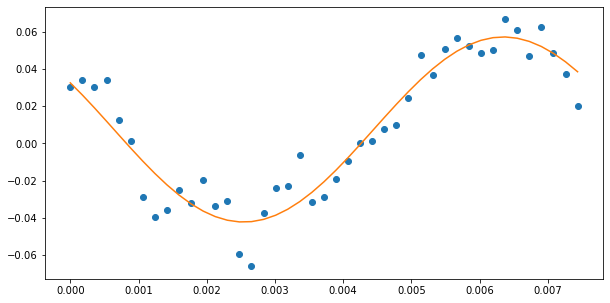

particle is:1
825.1429634800726
Storage modulus is:150.67487599024489
Loss modulus is:44.44864335327082
R^2: 0.9054657933082835
[ 0.05625583  2.85473202 -0.01140937]


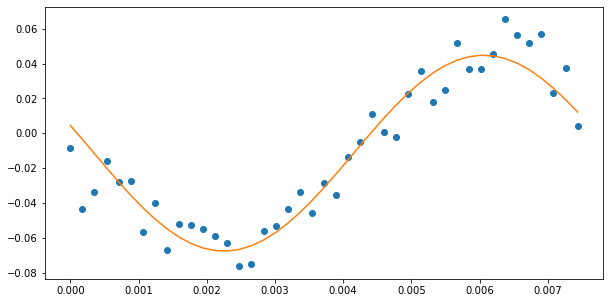

particle is:17
825.1429634800726
Storage modulus is:142.74612098431072
Loss modulus is:77.11522657719453
R^2: 0.9015342342123157
[ 0.05447012  2.6462841  -0.08764941]


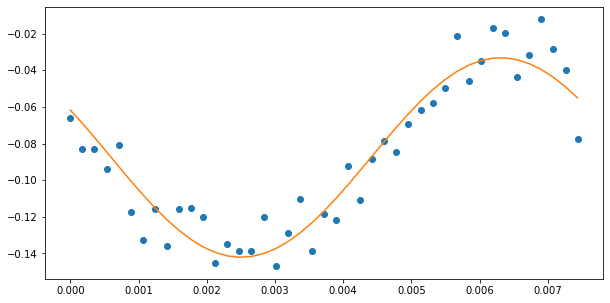

particle is:19
825.1429634800726
Storage modulus is:248.06975633413978
Loss modulus is:35.14188762824581
R^2: 0.879125215699062
[0.03527276 3.00086771 0.01213172]


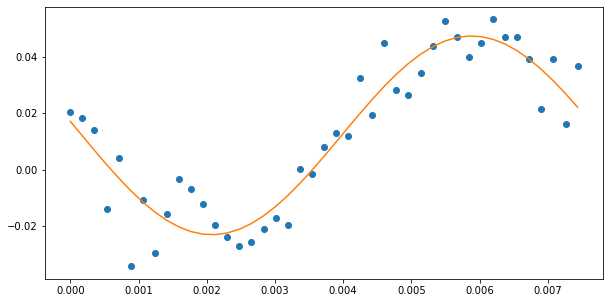

particle is:21
479.4749652654476
Storage modulus is:-592.4877159201501
Loss modulus is:2.703732834572052e-12
R^2: 0.042588932019550274
[ 1.49158657e-02  4.53252543e-15 -1.80442811e-02]


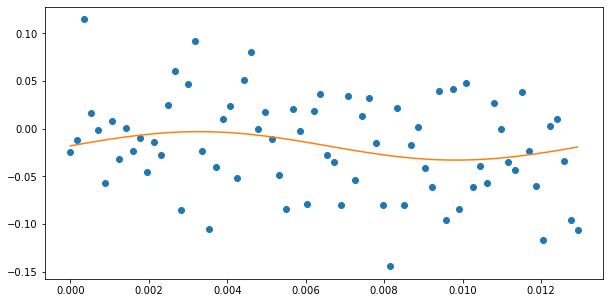

particle is:26
1223.4878424014871
Storage modulus is:164.31438767366666
Loss modulus is:390.2129273306268
R^2: 0.7821764009379442
[ 0.02087275  1.9693497  -0.00456748]


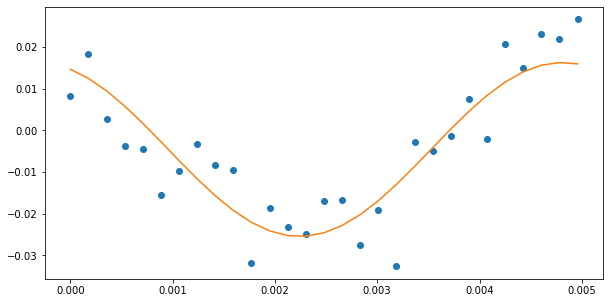

particle is:28
865.3938397473933
Storage modulus is:-324.75028507654457
Loss modulus is:1.8398853721234334e-13
R^2: 0.14394838805632548
[ 2.72131160e-02  2.67719196e-16 -3.96001555e-03]


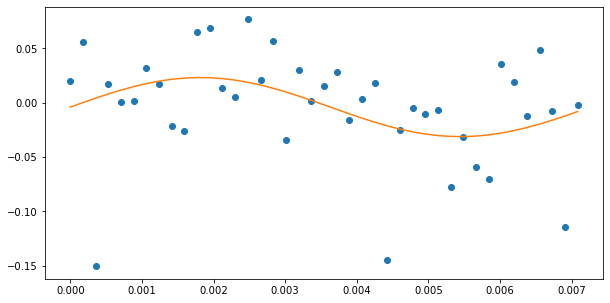

particle is:33
825.1429634800726
Storage modulus is:180.90703356744777
Loss modulus is:86.9209307708611
R^2: 0.8915268545996899
[0.04403206 2.69368839 0.00356648]


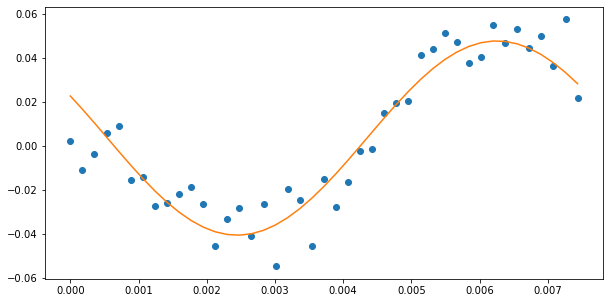

particle is:35
825.1429634800726
Storage modulus is:221.13584119729293
Loss modulus is:44.99770133393023
R^2: 0.8864017816043807
[0.03916144 2.94084893 0.04228401]


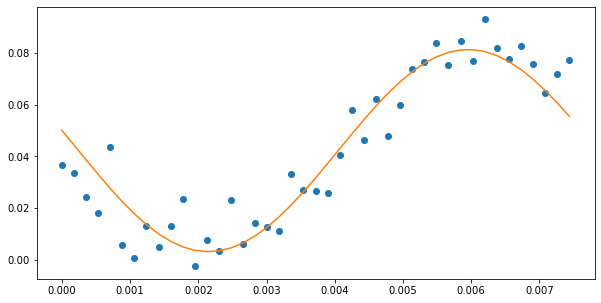

particle is:36
844.7892245153124
Storage modulus is:811.0577690143286
Loss modulus is:3.601820037843278e-13
R^2: 0.018366339497465467
[0.01089622 3.14159265 0.01402762]


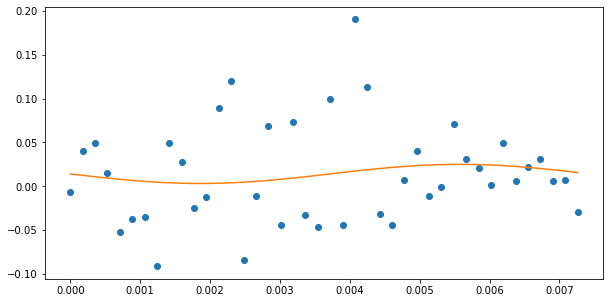

particle is:37
865.3938397473933
Storage modulus is:123.24180830211631
Loss modulus is:76.01986719961465
R^2: -0.6548432490035927
[0.06103147 2.58888632 0.1       ]


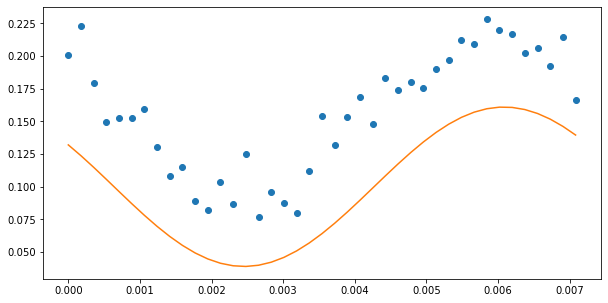

particle is:38
825.1429634800726
Storage modulus is:232.28895407622437
Loss modulus is:47.17258805398226
R^2: 0.8753279328569425
[0.03728411 2.94124002 0.01849507]


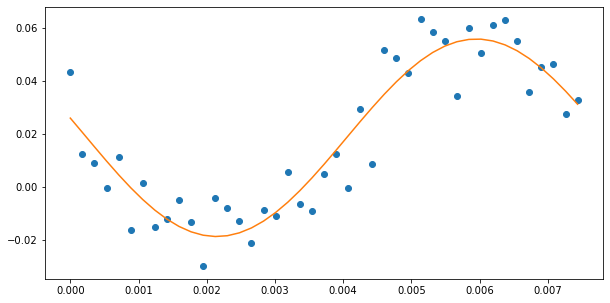

particle is:39
844.7892245153124
Storage modulus is:199.11730769368432
Loss modulus is:92.285059105356
R^2: 0.84979297178281
[0.0402685  2.70759304 0.01283114]


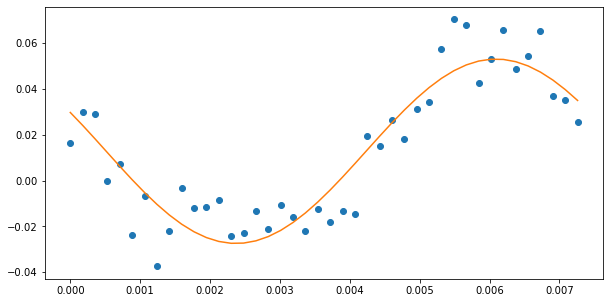

particle is:46
844.7892245153124
Storage modulus is:533.483664024032
Loss modulus is:2.3691433882434865e-13
R^2: 0.015046501993465022
[0.01656558 3.14159265 0.02453465]


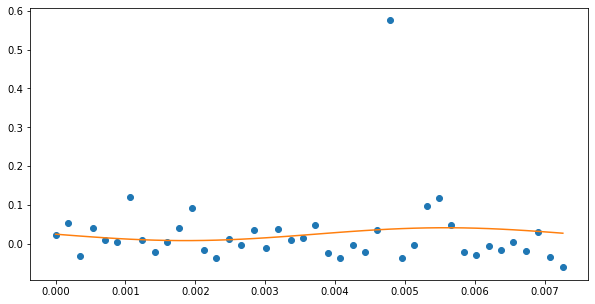

particle is:50
825.1429634800726
Storage modulus is:293.90071080499587
Loss modulus is:37.97514242917177
R^2: 0.8506330463668155
[0.02982166 3.01309382 0.01181473]


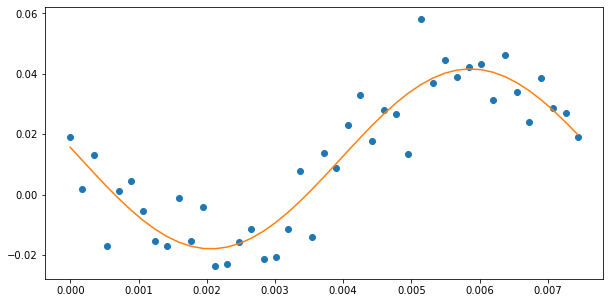

particle is:54
844.7892245153124
Storage modulus is:268.42540070771355
Loss modulus is:119.03146391248325
R^2: 0.8099115713345777
[0.03009692 2.72420458 0.00459428]


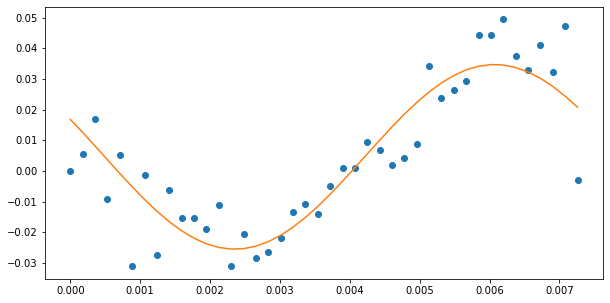

particle is:55
825.1429634800726
Storage modulus is:310.5385917584796
Loss modulus is:88.40318693583684
R^2: 0.9078965383728714
[0.02737103 2.86425228 0.00692597]


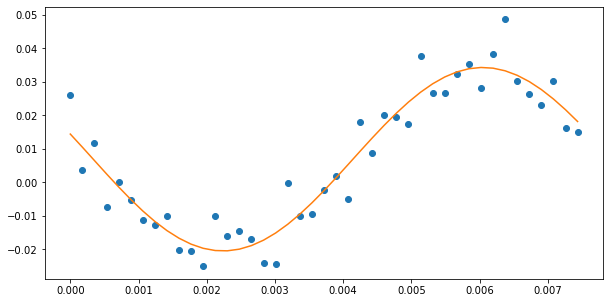

particle is:57
865.3938397473933
Storage modulus is:343.65049265732455
Loss modulus is:409.1596301507811
R^2: -0.586180025367786
[ 0.01653938  2.26939368 -0.09999999]


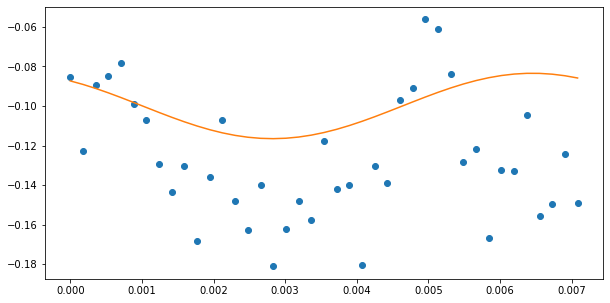

particle is:58
1043.563159695386
Storage modulus is:177.30663629466147
Loss modulus is:57.4867423300052
R^2: 0.8017528543635035
[0.04741307 2.82806444 0.07457156]


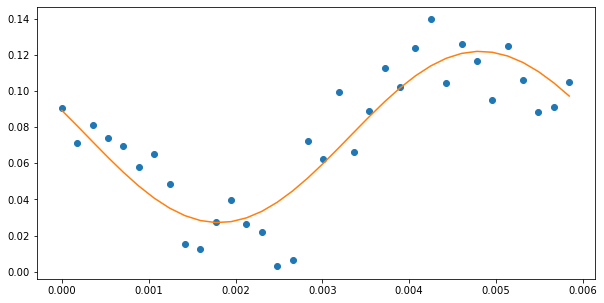

particle is:60
825.1429634800726
Storage modulus is:226.32013958699585
Loss modulus is:94.17097860398881
R^2: 0.8425245380117368
[0.03605209 2.7472876  0.00781285]


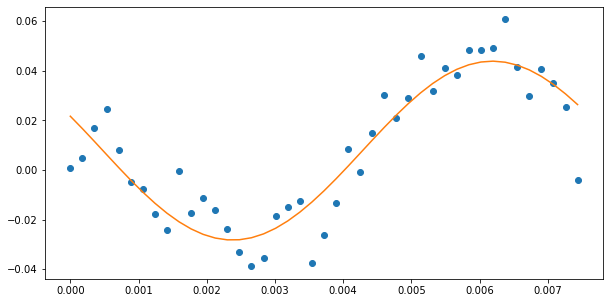

particle is:62
825.1429634800726
Storage modulus is:206.02015353359366
Loss modulus is:88.48997351233201
R^2: 0.8841261573315298
[0.0394142  2.73589896 0.02855863]


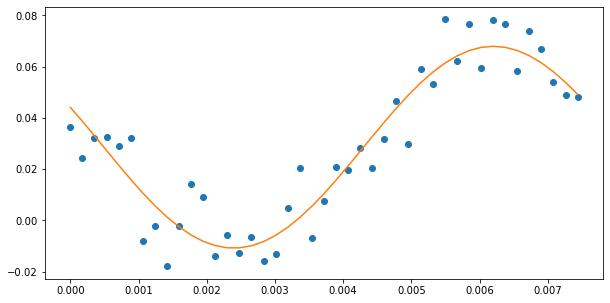

particle is:63
844.7892245153124
Storage modulus is:316.6685024716574
Loss modulus is:79.79157025291025
R^2: 0.7703980844904945
[0.02706177 2.89475893 0.02178282]


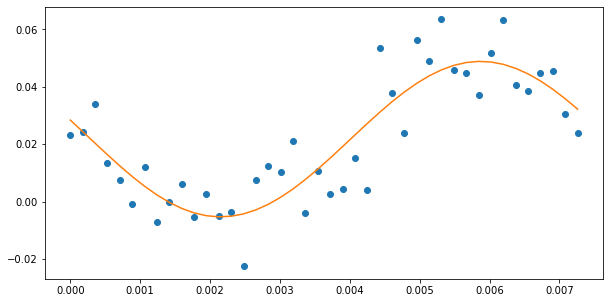

particle is:64
572.2765714458568
Storage modulus is:-1814.7734483361999
Loss modulus is:1323.2550872184686
R^2: 0.003266876614944847
[0.0039348  0.63002771 0.00570525]


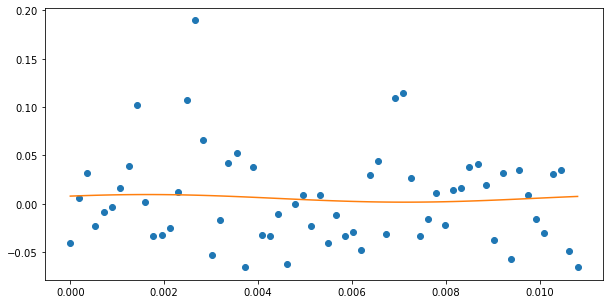

particle is:65
825.1429634800726
Storage modulus is:184.41681886784397
Loss modulus is:77.47740773580165
R^2: 0.9272222033261506
[0.04418054 2.74386167 0.0210027 ]


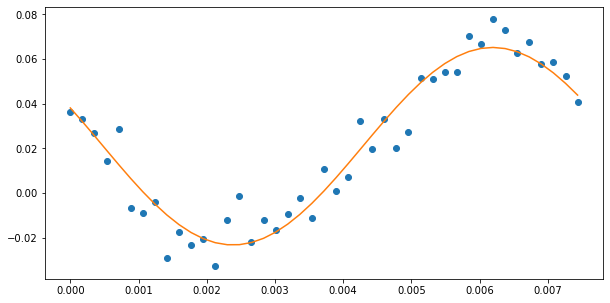

particle is:67
825.1429634800726
Storage modulus is:202.63645882796328
Loss modulus is:60.60488815091624
R^2: 0.8989755640585608
[0.04178367 2.85097841 0.01781243]


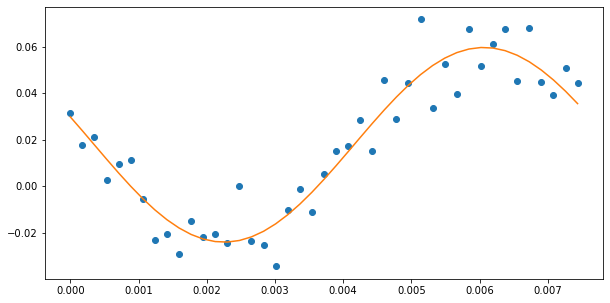

particle is:69
825.1429634800726
Storage modulus is:543.448002058277
Loss modulus is:946.1485558010332
R^2: 0.13408589407352323
[ 0.00809948  2.0921639  -0.02206585]


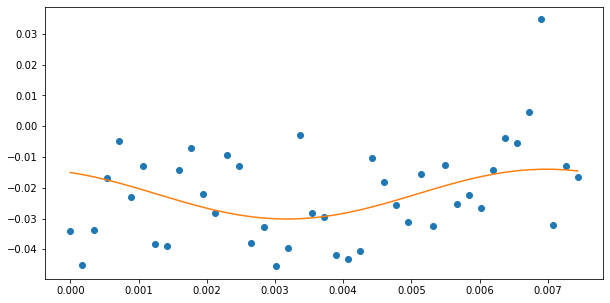

particle is:70
806.389714310071
Storage modulus is:46.157479049488515
Loss modulus is:2.0498038399758174e-14
R^2: 0.5962126954328331
[ 0.19146338  3.14159265 -0.07171768]


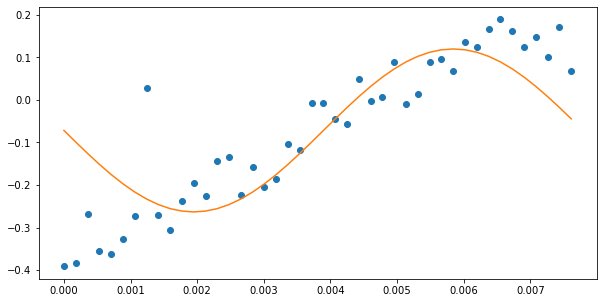

particle is:71
825.1429634800726
Storage modulus is:253.02723462713587
Loss modulus is:98.23557205957151
R^2: 0.8281889591775051
[0.03255919 2.77126418 0.01610275]


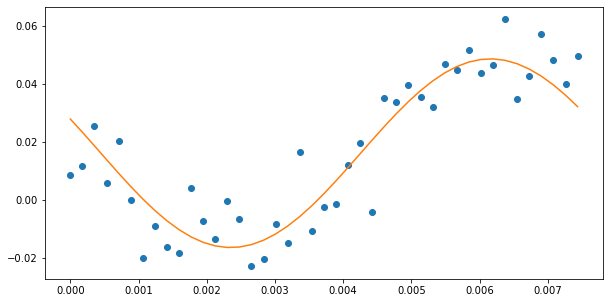

particle is:72
865.3938397473933
Storage modulus is:91.27181092403549
Loss modulus is:308.6299309776299
R^2: 0.7765403496770226
[ 0.02745893  1.85833313 -0.01671246]


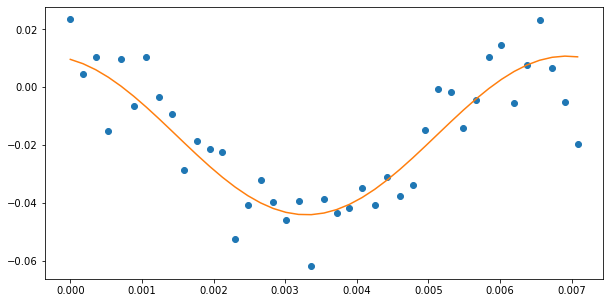

particle is:73
825.1429634800726
Storage modulus is:201.39626955589236
Loss modulus is:88.15357222504807
R^2: 0.876448768756185
[0.04019876 2.72900425 0.01436222]


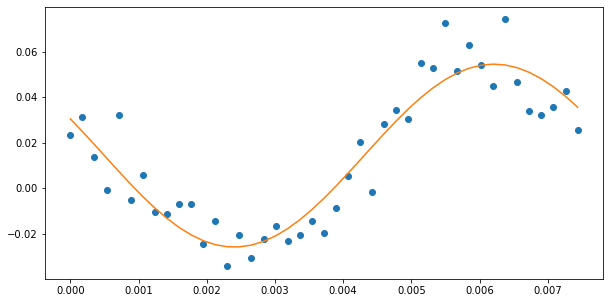

particle is:74
825.1429634800726
Storage modulus is:239.43501550842683
Loss modulus is:74.54581196029088
R^2: 0.8374892969206675
[0.03524115 2.8397645  0.01084633]


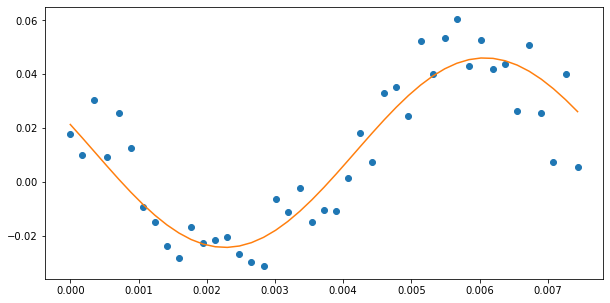

particle is:75
844.7892245153124
Storage modulus is:251.01503401487093
Loss modulus is:106.86218656736472
R^2: 0.8403047267293979
[0.03239362 2.73911209 0.00542382]


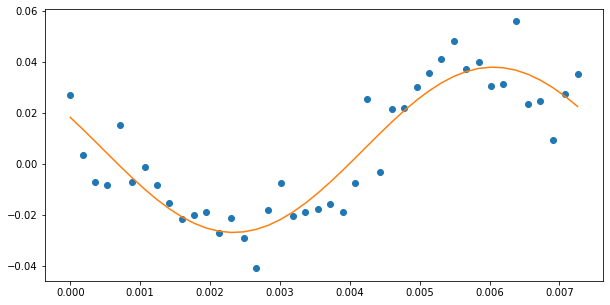

particle is:76
825.1429634800726
Storage modulus is:130.45991285543707
Loss modulus is:70.62678875059514
R^2: 0.9652994456364813
[ 5.95714532e-02  2.64540104e+00 -1.93597582e-03]


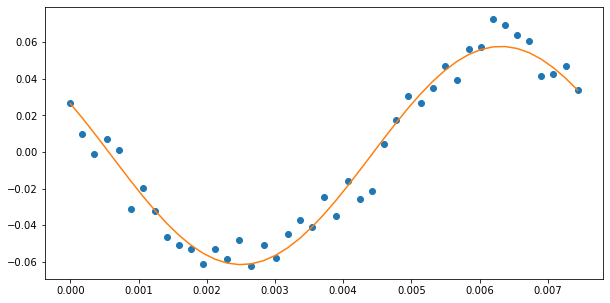

particle is:77
844.7892245153124
Storage modulus is:224.50059426684308
Loss modulus is:59.46776902128048
R^2: 0.8866424086320999
[0.03805263 2.88265051 0.0046781 ]


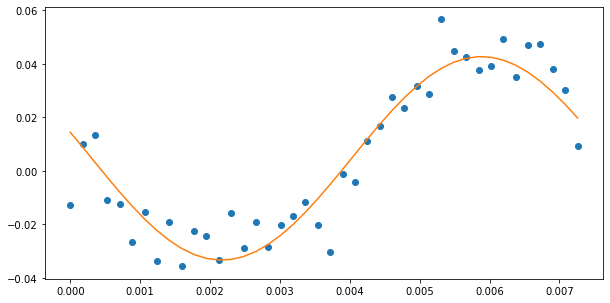

particle is:78
825.1429634800726
Storage modulus is:41.07200610759738
Loss modulus is:136.23608167638207
R^2: 0.608537549628589
[0.06210771 1.86360735 0.06037222]


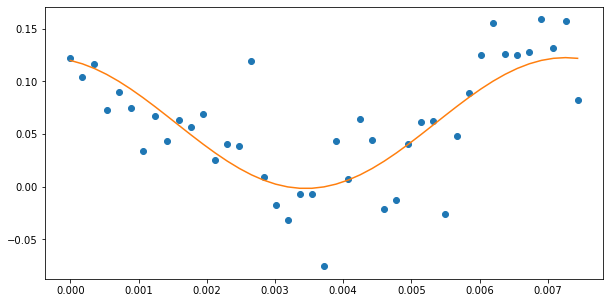

particle is:79
825.1429634800726
Storage modulus is:257.325552872177
Loss modulus is:82.72183611165514
R^2: 0.8704206019739715
[0.03269565 2.83055897 0.00983683]


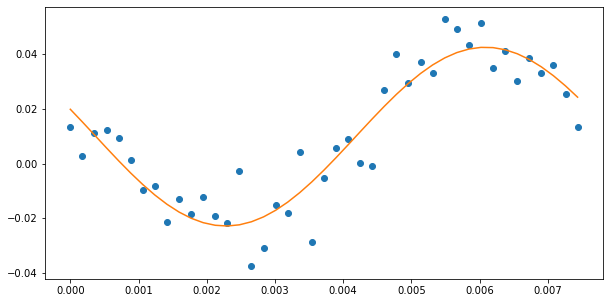

particle is:80
844.7892245153124
Storage modulus is:165.4684767169568
Loss modulus is:109.79588590595905
R^2: 0.9487792899902202
[ 0.04450278  2.55575388 -0.01244528]


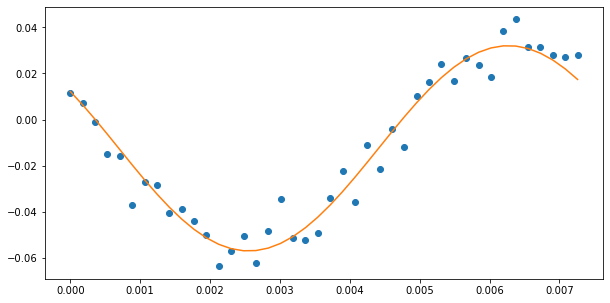

particle is:81
825.1429634800726
Storage modulus is:206.97276921503484
Loss modulus is:65.7134294359907
R^2: 0.9430386411602458
[0.04069672 2.834161   0.00809162]


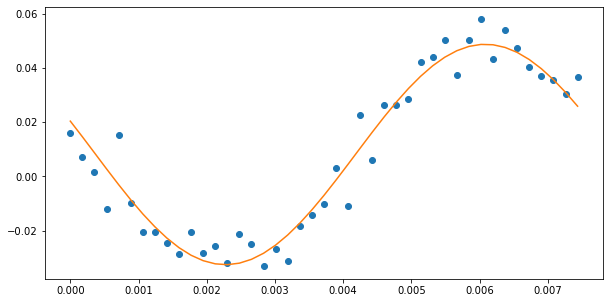

particle is:82
844.7892245153124
Storage modulus is:285.5605980792963
Loss modulus is:81.14545659803622
R^2: 0.8172717349114273
[0.02976921 2.86472876 0.01565576]


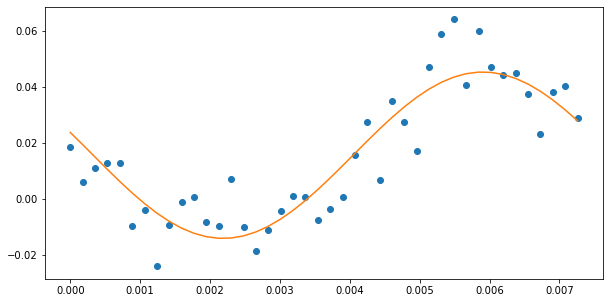

particle is:88
529.5693646215392
Storage modulus is:-249.56628256750741
Loss modulus is:3.0563054912140185e-14
R^2: 0.10514468276774513
[ 3.54113027e-02  4.89810243e-19 -1.77558611e-04]


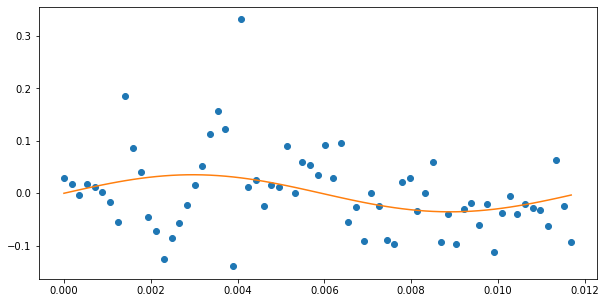

particle is:90
844.7892245153124
Storage modulus is:277.25175668843923
Loss modulus is:57.88814827952987
R^2: 0.8584365854931393
[0.03120237 2.93575703 0.01107934]


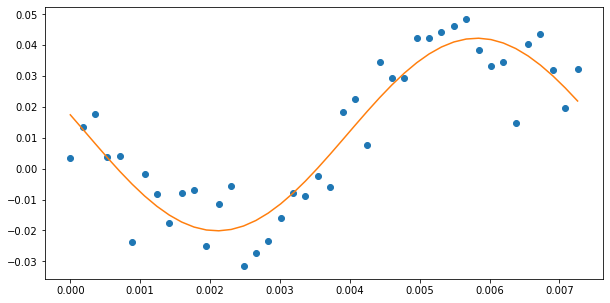

particle is:94
844.7892245153124
Storage modulus is:188.5662156032215
Loss modulus is:21.672448350630507
R^2: 0.8564427278814419
[0.04656014 3.02716192 0.03235483]


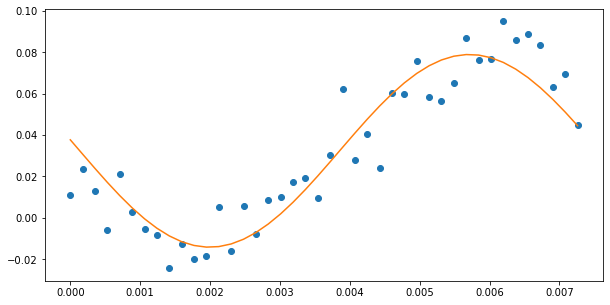

In [44]:
data2=utils.analyze_wavelength_modulus(wavelength2,gamma2list_w2,real_stress,framerate,imgname)

In [45]:
data2

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
0,0,153.643233,89.540114,825.142963,0.905999,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
1,1,150.674876,44.448643,825.142963,0.905466,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
2,17,142.746121,77.115227,825.142963,0.901534,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
3,19,248.069756,35.141888,825.142963,0.879125,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
5,26,164.314388,390.212927,1223.487842,0.782176,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
7,33,180.907034,86.920931,825.142963,0.891527,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
8,35,221.135841,44.997701,825.142963,0.886402,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
11,38,232.288954,47.172588,825.142963,0.875328,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
12,39,199.117308,92.285059,844.789225,0.849793,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...
14,50,293.900711,37.975142,825.142963,0.850633,0p5low_alg_12p5mM_2000ul_100um_20231012_94842_...


In [46]:
data2 = data2[data2['Droplet Number'] != 72]

# Concatenate

In [47]:
final_output = pd.concat([data1, data2], ignore_index=True)

In [48]:
final_output.to_csv('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/results/095759_new.csv', index=False)